# Imports

In [2]:

from bs4 import BeautifulSoup
import requests
import codecs
import re
import time
import pandas as pd
from pandas import DataFrame
import base64
from os import listdir
from os.path import isfile, join
import json
from tqdm import tqdm
from pyinstrument import Profiler
import lxml
import cchardet
import concurrent.futures
from itertools import chain
import numpy
import re
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from scipy.stats import chi2_contingency
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
# --------cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# -------- classification
import sklearn
from sklearn import neighbors, tree, ensemble, naive_bayes, svm
#  KNN
from sklearn.neighbors import KNeighborsClassifier
#  Decision Tree; Random Forest
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#  Naive Bayes
from sklearn.naive_bayes import GaussianNB
#  SVM classifier
from sklearn.svm import SVC
# --------  metrics:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import r2_score
from xml.sax.handler import all_features
from sklearn.metrics import confusion_matrix

profiler = Profiler()
MAX_THREADS = 30

# Selectors

In [2]:
class WikipediaSelectors:
    imdb_link_selector = 'a[href*="imdb"]'
    actor_name_selector = '#firstHeading'
    actor_infobox_key = 'th.infobox-label'
    actor_infobox_value = 'td.infobox-data'

class ImdbSelectors:
    date_of_birth_and_location_container = '#name-born-info'
    birth_location = 'a[href*="birth_place"]'
    actor_name_from_imdb = '.itemprop'
    links_movies_known_for = '.knownfor-title-role a'
    metadata_list_items = 'div[data-testid="title-pc-wide-screen"] > ul > li'
    box_office_list_items = 'section[data-testid="BoxOffice"] > div >ul > li'



# Global helper functions

In [147]:

def get_links(filename):
    with codecs.open(filename, "r", "utf-8") as file: # read data from file
        soup3 = BeautifulSoup(file.read())
    list_items = soup3.select("#mw-pages > div > div > div > ul > li > a")
    return list(map(lambda item: wikipedia_base_url + item['href'], list_items))

def save_text_file(filename: str, data: str):
    with codecs.open(filename, "w", "utf-8") as file: # save all data to file
        file.write(data)

def load_files_as_soup(file_list):
    for file in file_list:
        yield soupify(load_str(file))

def save_html_file(filename: str, data: str):
    save_text_file("./"+filename+".html", data)

def load_str(file_name: str):
    text = None
    try:
        with open(file_name, 'rb') as file:
            text = file.read().decode()
    except Exception as e:
        print("Could not find/load file", e)
    return text

def load_html_file(file_name: str):
    return load_str(file_name + '.html')
def get_html(url):
    try:
        response = requests.get(url)
        return response.text
    finally:
        time.sleep(1)

def cache_html(url: str, file_name: str):
    if isfile(file_name+".html"):
        return load_html_file(file_name)
    else:
        html = get_html(url)
        save_html_file(file_name, html)
        return html

def soupify(html: str) -> BeautifulSoup:
    return BeautifulSoup(html,'lxml')

def use_or_none(val, fn):
    if val is not None:
        return fn(val)
    return None

def create_filename_from_string(string: str):
    return "".join([c for c in string if c.isalpha() or c.isdigit() or c==' ']).rstrip()

def get_page_title(html: str):
    soup = BeautifulSoup(html)
    page_name = soup.select_one('#firstHeading').text
    return create_filename_from_string(page_name).replace(' ', '_')

def put_user_infobox_in_a_dict(file_name1, Dit):
    html1 = load_str(f'znames_actors/{file_name1}')
    soup5 = BeautifulSoup(html1,'html.parser')
    the_whole_table = soup5.find("table", attrs={"class":"infobox biography vcard"})
    # the_whole_table_2 = soup5.find("table", attrs={"class":"infobox vcard plainlist"})
    if file_name1.endswith('.html'):
        file_name = file_name1[0:-len(".html")]
    lis = []
    Dit[file_name] = {}
    if the_whole_table is not None:
        for info in the_whole_table.findAll("td", attrs={"class":"infobox-data"}):
            lis.append(info.text)
        for index, label in enumerate(the_whole_table.findAll("th", attrs={"class":"infobox-label"})):
            Dit[file_name][label.text] = lis[index]
    return Dit

def put_user_infobox_in_a_dict2(soup): # {'a':3, 'b':2}
    the_whole_table = soup.find("table", attrs={"class":"infobox biography vcard"})
    user_infobox = {}
    if the_whole_table is not None:
        table_row = the_whole_table.select('tr')
        for row in table_row:
            key = use_or_none(row.select_one(WikipediaSelectors.actor_infobox_key), lambda k: k.text.replace('\xa0', ' ').lower().replace('alma mater', 'education'))
            if key is None:
                continue
            if key not in ['education', 'alma mater', 'occupation', 'years active']:
                continue

            val = use_or_none(row.select_one(WikipediaSelectors.actor_infobox_value), lambda v: v.text.replace('\n', ', ').lower())
            if val is None:
                continue

            if user_infobox.get(key) is not None:
                user_infobox[key] += f' {val}' # put value of row inside key
            else:
                user_infobox[key] = val
    return user_infobox

def unite_education_col(df_good):
    df_good["new"] = df_good["Education"].fillna('') + ' ' +df_good["Alma\xa0mater"].fillna('')
    df_good=df_good.drop(columns=['Education', 'Alma\xa0mater'])
    df_good["Education"]=df_good["new"]
    df_good=df_good.drop(columns=["new"])
    return df_good

def get_page_title_imdb(html: str):
    soup = soupify(html)
    page_name = soup.select_one(WikipediaSelectors.imdb_link_selector)
    if page_name is not None:
        return create_filename_from_string(page_name.text).replace(' ', '_')

def run_async(fun, l: list):
    threads = min(MAX_THREADS, len(l))
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        results = list(tqdm(executor.map(fun, l), total=len(l)))
    return results

def flatten(li: list):
    data_flattened = []
    for sublist in li:
        for item in sublist:
            data_flattened.append(item)
    return data_flattened

# Crawling links from Wikipedia

In [4]:
wikipedia_base_url = 'https://en.wikipedia.org'

In [134]:
def list_links(url,name):
    response1 = requests.get(wikipedia_base_url + url)
    soup1 = BeautifulSoup(response1.content, "html.parser")
    selectResults = soup1.select("#mw-pages > a:nth-child(3)")
    next_page = list(filter(lambda x: 'next' in x.text, selectResults))
    next_page = next_page[0]['href']
    i = 0
    while True:
        soup2 = BeautifulSoup(requests.get(wikipedia_base_url + next_page).content, "html.parser")
        next_page = list(filter(lambda x: 'next' in x.text, soup2.select("#mw-pages > a:nth-child(4)"))) # Could be empty
        soup1.append(soup2)
        if next_page is None or len(next_page) == 0:
            break

        next_page = next_page[0]['href']
        time.sleep(1)

    with codecs.open("./"+name+".html", "w", "utf-8") as file: # save all data to file
        file.write(str(soup1.contents))

# 2 lists of american actors and actresses wiki links

In [118]:
list_links("/wiki/Category:American_film_actresses", "actresses_links")

In [32]:
list_links("/wiki/Category:American_male_film_actors", "actors_links")

# Caching wiki pages to html files

In [ ]:
# get female links
links = get_links('actresses_links.html')

# get male links and join
links = links + get_links('actors_links.html')

# take only unique
links = pd.Series(list(set(links)))

# print
links

base_folder = 'actors'
for link in links:
    try:
        html = get_html(link)
        page_title = get_page_title(html)
        save_html_file(f'{base_folder}/{page_title}', html)
    except Exception as e:
        print(e)
    finally:
        time.sleep(.5)


# Scraping IMDB actors and actresses links

In [ ]:

def links_imdb():
    list_imdb_links=[]
    result=[]
    my_path="D:\Python Final Project\PythonFinalProject\znames_actors"
    onlyfiles1 = [f for f in listdir(my_path) if isfile(join(my_path, f))]
    for file_name in tqdm(onlyfiles1):
        html = load_str(f'znames_actors/{file_name}')
        soup = soupify(html)
        result= soup.select(WikipediaSelectors.imdb_link_selector)
        if result.__len__() != 0:
            new_res=result[-1]
            list_imdb_links.append(new_res['href'])
    return list_imdb_links



l=links_imdb()


# Converting mobile links to web links

In [ ]:
def links_imdb_without_mobile():
    list_imdb_links=[]
    result=[]
    my_path="D:\Python Final Project\PythonFinalProject\znames_actors"
    onlyfiles1 = [f for f in listdir(my_path) if isfile(join(my_path, f))]
    for file_name in tqdm(onlyfiles1):
        html = load_str(f'znames_actors/{file_name}')
        soup = soupify(html)
        result= soup.select(WikipediaSelectors.imdb_link_selector)
        if result.__len__() != 0:
            new_res=result[-1]
            imdb_link = new_res['href']
            if 'https://m.' in imdb_link:
                imdb_link = imdb_link.replace('https://m.', 'https://')
            list_imdb_links.append(imdb_link)
    return list_imdb_links

l=links_imdb_without_mobile()

In [ ]:

save_text_file("imdb_links_list.txt", json.dumps(l))

In [13]:
imdb_links_list = json.loads(load_str("imdb_links_list.txt"))

# Caching imdb pages to html files

In [10]:
def download_imdb_link(link):
    try:
        filename = "".join(i for i in link if i not in "\/:*?<>|")
        cache_html(link, f'{base_folder}/{filename}')
    except Exception as e:
        return (link,e)

# Run a function on an array with multi-threading
## generic function that can use every array and function
### bonus: shows the progress bar!

In [ ]:
base_folder = './imdb_links2'
links_with_exception = list()
batch = imdb_links_list
threads = min(MAX_THREADS, len(batch))
def run(fun):
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        results = list(tqdm(executor.map(fun, batch), total=len(batch)))
    return results
run(download_imdb_link)

# Brings all the files from the computer folder
takes the headers from each html file and puts it in a list

In [ ]:
import glob

file_list = glob.glob('./imdb_links2/*.html')[:1000]
headers = list()
for soup in tqdm(load_files_as_soup(file_list), total=len(file_list)):
    headers.append(use_or_none(soup.select_one("h1.header"), lambda tag: tag.text))

print(len(list(filter(lambda a: a is not None, headers))))

# Scraping from wikipedia the actorname, occupation, education and years active for each actor from the actors folder

In [ ]:
def get_user_details(file_name):
    html = load_str(f'znames_actors/{file_name}')
    soup = soupify(html)
    user_info = put_user_infobox_in_a_dict2(soup)
    return {
        'Name': soup.select_one(WikipediaSelectors.actor_name_selector).text,
        **user_info
    }

def scrape_actor_name():
    my_path="D:\Python Final Project\PythonFinalProject\znames_actors"
    onlyfiles = [f for f in listdir(my_path) if isfile(join(my_path, f))]

    scraped_actors = []
    threads = 30
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        results = list(tqdm(executor.map(get_user_details, onlyfiles), total=len(onlyfiles)))

    scraped_actors_df = DataFrame(results)
    scraped_actors_df.set_index('Name')
    return scraped_actors_df

actor_data = scrape_actor_name()
actor_data.to_csv('mainpage_actor_data.csv')

# Scraping from the IMDB actors pages the 4 most known for movies they played in
## and puts them in a dictionary, where the key is the actor name and the value is their list of movies

In [ ]:
def get_known_for_links():
    dict_of_actorname_and_links_to_movies = {}
    imdb_links_path = "D:\Python Final Project\PythonFinalProject\imdb_links2"
    imdb_files = [f for f in listdir(imdb_links_path) if isfile(join(imdb_links_path, f))]
    # limit = 100

    # for index, file_name in zip(range(limit), imdb_files):
    for file_name in tqdm(imdb_files):
        # print(str(index) + ' ' + file_name)
        html = load_str(f'imdb_links2/{file_name}')
        soup = soupify(html)
        actor_name_selector = soup.select_one(ImdbSelectors.actor_name_from_imdb)
        if actor_name_selector is not None:
            actor_name = actor_name_selector.text
        # else:
            # print('actor name seslector is noneeeee')
        all_the_known_for_movies_selector = soup.select('.knownfor-title-role a[href]')
        list_of_known_for_movies = []
        key = actor_name
        for linki in all_the_known_for_movies_selector:
            if linki is not None:
                link_good = 'https://www.imdb.com'+linki['href']
                list_of_known_for_movies.append(link_good)

        value = list_of_known_for_movies

        dict_of_actorname_and_links_to_movies[key] = value

    return dict_of_actorname_and_links_to_movies

dict_of_movies_by_actor_name=get_known_for_links()
save_text_file("imdb_movies_by_actor_name.txt", json.dumps(dict_of_movies_by_actor_name))

# Gathering the imdb movie links in a list and then in a text file

In [6]:
dict_of_movies_by_actor_name = json.loads(load_str("imdb_movies_by_actor_name.txt"))
list_only_links= []
for key in dict_of_movies_by_actor_name:
    for value in dict_of_movies_by_actor_name[key]:
        list_only_links.append(value)

save_text_file("imdb_movies_only_links.txt", json.dumps(list_only_links))

In [90]:
dict_of_movies_by_actor_name = json.loads(load_str("imdb_movies_by_actor_name.txt"))

# Creating a dictionary of only the actors names and their movies ids

In [94]:
dict_actors_and_movies_ids_only = {}
for key, links_array in tqdm(dict_of_movies_by_actor_name.items()):
    if dict_actors_and_movies_ids_only.get(key) is None:
      dict_actors_and_movies_ids_only[key] = list()
    for idx, link in enumerate(links_array):
        dict_actors_and_movies_ids_only[key].append(link.replace('https://www.imdb.com/title/', '').split("/")[0])

print(dict_actors_and_movies_ids_only)
save_text_file("imdb_actors_and_movie_id.txt", json.dumps(dict_actors_and_movies_ids_only))


100%|██████████| 19445/19445 [00:00<00:00, 127430.97it/s]


{'Diana Darrin': ['tt0049022', 'tt0050539', 'tt0051290', 'tt0052341'], 'Jeff Kahn': ['tt0405422', 'tt0942385', 'tt0817538', 'tt0115798'], 'Anzu Lawson': ['tt4655480', 'tt2249007', 'tt2741602', 'tt0364845'], 'Kevyn Morrow': ['tt0248667', 'tt0180734', 'tt0303714', 'tt0119311'], 'Christopher Rydell': ['tt0082846', 'tt0089560', 'tt0089222', 'tt0097530'], 'Teddi Sherman': ['tt0040370', 'tt0061277', 'tt0051311', 'tt0053341'], 'Doreen English': ['tt0040918'], 'Blythe Metz': ['tt0478216', 'tt0469043', 'tt0758739', 'tt1829013'], 'Guy Nardulli': ['tt0092325', 'tt7991608', 'tt7414406', 'tt9054904'], 'Alexys Nycole Sanchez': ['tt1375670', 'tt2191701', 'tt1924211'], 'Fred Astaire': ['tt0072308', 'tt0050419', 'tt0053137', 'tt0031983'], 'Lauren Bacall': ['tt0037382', 'tt0117057', 'tt0038355', 'tt0071877'], 'John Belushi': ['tt0072562', 'tt0077975', 'tt0080455', 'tt0078723'], 'Ingrid Bergman': ['tt0034583', 'tt0036855', 'tt0038109', 'tt0077711'], 'Humphrey Bogart': ['tt0034583', 'tt0043265', 'tt003387

# Gathering all the unique movies' ids from the dictionary

In [95]:
list_of_movies_id_no_double = sorted({x for v in dict_actors_and_movies_ids_only.values() for x in v})

print(list_of_movies_id_no_double)

['tt0000528', 'tt0000628', 'tt0000629', 'tt0000640', 'tt0000644', 'tt0000679', 'tt0000685', 'tt0000697', 'tt0000709', 'tt0000734', 'tt0000747', 'tt0000748', 'tt0000754', 'tt0000770', 'tt0000787', 'tt0000792', 'tt0000801', 'tt0000807', 'tt0000816', 'tt0000826', 'tt0000832', 'tt0000833', 'tt0000898', 'tt0000907', 'tt0000909', 'tt0000928', 'tt0000958', 'tt0000966', 'tt0000974', 'tt0000981', 'tt0001033', 'tt0001050', 'tt0001067', 'tt0001077', 'tt0001079', 'tt0001170', 'tt0001175', 'tt0001178', 'tt0001207', 'tt0001217', 'tt0001236', 'tt0001243', 'tt0001257', 'tt0001259', 'tt0001283', 'tt0001319', 'tt0001327', 'tt0001333', 'tt0001371', 'tt0001405', 'tt0001439', 'tt0001452', 'tt0001456', 'tt0001459', 'tt0001463', 'tt0001546', 'tt0001576', 'tt0001577', 'tt0001598', 'tt0001635', 'tt0001686', 'tt0001706', 'tt0001746', 'tt0001789', 'tt0001801', 'tt0001840', 'tt0001872', 'tt0001873', 'tt0001877', 'tt0001948', 'tt0001981', 'tt0001989', 'tt0002031', 'tt0002062', 'tt0002082', 'tt0002087', 'tt0002101'

In [96]:
save_text_file("movies_ids_TEST.txt", json.dumps(list_of_movies_id_no_double))

# Gathering all the unique movies' links from the dictionary


In [ ]:
list_of_movies_link_no_double = sorted({x for v in dict_of_movies_by_actor_name.values() for x in v})
print(list_of_movies_link_no_double)

In [ ]:
list_link = list_of_movies_link_no_double

# Caching imdb movies' pages to html files

In [ ]:
base_folder = './imdb_movie_links'

links_with_exception = list()
threads = min(MAX_THREADS, len(list_link))

def run(fun):
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        results = list(tqdm(executor.map(fun, list_link), total=len(list_link)))
    return results

def download_imdb_movie_link(link):
    try:
        filename = "".join(i for i in link if i not in "\/:*?<>|")
        cache_html(link, f'{base_folder}/{filename}')
    except Exception as e:
        return (link, e)


run(download_imdb_movie_link)


# Scraping the name, genre, rating, keyword, main actors, budget and gross for each movie
## puts the data into a dataframe

In [100]:
class movie_details:
    def __init__(self, file_name):
        self.file_name = file_name
        self.name = None
        self.genre = None
        self.rating = None
        self.keywords = None
        self.main_actors = None
        self.budget = None
        self.gross_worldwide = None
        match = re.search(r'(?P<id>tt[0-9][0-9][0-9][0-9][0-9][0-9][0-9])', file_name)
        self.id = match.group('id')

    def __str__(self) -> str:
        return self.name

dict_of_actorname_and_links_to_movies = {}
imdb_movies_links_path = "D:\Python Final Project\PythonFinalProject\imdb_movie_links"
imdb_movies_files = [f for f in listdir(imdb_movies_links_path) if isfile(join(imdb_movies_links_path, f))]

movies = []
errors = []
def load_movie_details(file_name):
    match = re.search(r'(?P<id>tt[0-9][0-9][0-9][0-9][0-9][0-9][0-9])', "httpswww.imdb.comtitlett0043585ref_=nm_knf_t4")
    id = match.group('id')
    movie = movie_details(file_name)
    try:
        html = load_str(f'imdb_movie_links/{file_name}')
        soup = soupify(html)
        movie_name_selector = soup.select_one('.TitleHeader__TitleText-sc-1wu6n3d-0')
        if movie_name_selector is not None:
            movie.name = movie_name_selector.text
        movie_genre_selector = soup.select_one('a[href*="genres"]')
        if movie_genre_selector is not None:
            movie.genre = movie_genre_selector.text
        movie_rating_selector =soup.select_one('.AggregateRatingButton__RatingScore-sc-1ll29m0-1')
        if movie_rating_selector is not None:
            movie.rating = movie_rating_selector.text
        movie_keywords_selector = soup.select_one('a[href*="keyword"]')
        if movie_keywords_selector is not None:
            movie.keywords = movie_keywords_selector.text

        metadata_list_items = soup.select(ImdbSelectors.metadata_list_items)
        metadata_list_items = [item for item in metadata_list_items if "Stars" in list(item.children)[0].text]
        if len(metadata_list_items):
            stars_list = metadata_list_items.pop()
            movie.main_actors = str.join(';;;',list(map(lambda item: item.text, list(stars_list.select("ul li a")))))

        box_office_list_items = soup.select(ImdbSelectors.box_office_list_items)
        box_office_list_items = list(map(lambda item: list(item.children), box_office_list_items))
        budget_fields = list(map(lambda item: (item[0].text, item[1].text), box_office_list_items))
        for key, value in budget_fields:
            if 'Budget' in key:
                movie.budget = value
            if 'Gross worldwide' in key:
                movie.gross_worldwide = value
    except Exception as e:
        errors.append((file_name, str(e)))

    return movie.__dict__

dddff = DataFrame(run_async(load_movie_details, imdb_movies_files))
print(dddff)
dddff.to_csv("movies_with_ids.csv")
print(errors)

100%|██████████| 30521/30521 [4:28:42<00:00,  1.89it/s]  


                                  file_name  \
0      httpswww.imdb.comtitlett0000528.html   
1      httpswww.imdb.comtitlett0000628.html   
2      httpswww.imdb.comtitlett0000629.html   
3      httpswww.imdb.comtitlett0000640.html   
4      httpswww.imdb.comtitlett0000644.html   
...                                     ...   
30516  httpswww.imdb.comtitlett9904648.html   
30517  httpswww.imdb.comtitlett9909104.html   
30518  httpswww.imdb.comtitlett9909216.html   
30519  httpswww.imdb.comtitlett9909228.html   
30520  httpswww.imdb.comtitlett9912890.html   

                                                    name        genre rating  \
0                         Raffles, the Amateur Cracksman    Adventure    6.5   
1                               The Adventures of Dollie       Action    5.7   
2                                       After Many Years        Drama    5.7   
3                                        An Awful Moment        Drama    4.4   
4                                  

# Scraping all time oscar winners from a table we found on the site Behindthename
## also scraping the year they won and the movie they played in

In [12]:
def scrape_actor_oscar_win():
    listy = []
    link_of_oscar_win_table = "https://www.behindthename.com/namesakes/list/oscar/category"
    responsee = requests.get(link_of_oscar_win_table)
    soup = BeautifulSoup(responsee.content, "html.parser")
    actor_oscar_win_table = soup.select('.r0r1 tr')
    for item in actor_oscar_win_table:
        each_col = []
        each_col_selector = item.select('td')
        for item1 in each_col_selector:
            each_col.append(item1.text)
        listy.append(each_col)
    return listy

list_of_actors_won_oscar_and_year_and_movie= []
for one_list in scrape_actor_oscar_win():
    arr = numpy.array(one_list)
    if(len(arr) > 1):
        if arr[2] == 'actor' or 'actress':
            list_each_actor_year_movie = []
            actor_name = arr[0]
            list_each_actor_year_movie.append(actor_name)
            year = arr[1]
            list_each_actor_year_movie.append(year)
            movie_name = arr[3]
            list_each_actor_year_movie.append(movie_name)

            list_of_actors_won_oscar_and_year_and_movie.append(list_each_actor_year_movie)

print(list_of_actors_won_oscar_and_year_and_movie)



[['Ronald Colman', '1947', 'A Double Life'], ['Kevin Kline', '1988', 'A Fish Called Wanda'], ['Lionel Barrymore', '1931', 'A Free Soul'], ['Paul Scofield', '1966', 'A Man for All Seasons'], ['Karl Malden', '1951', 'A Streetcar Named Desire'], ['Martin Balsam', '1965', 'A Thousand Clowns'], ['James Dunn', '1945', 'A Tree Grows in Brooklyn'], ['Chris Cooper', '2002', 'Adaptation'], ['James Coburn', '1998', 'Affliction'], ['George Sanders', '1950', 'All About Eve'], ['Broderick Crawford', '1949', "All the King's Men"], ['Jason Robards', '1976', "All the President's Men"], ['F. Murray Abraham', '1984', 'Amadeus'], ['Kevin Spacey', '1999', 'American Beauty'], ['Louis Gossett, Jr.', '1982', 'An Officer and a Gentleman'], ['John Gielgud', '1981', 'Arthur'], ['Jack Nicholson', '1997', 'As Good As It Gets'], ['Christopher Plummer', '2011', 'Beginners'], ['Melvyn Douglas', '1979', 'Being There'], ['Charlton Heston', '1959', 'Ben-Hur'], ['Hugh Griffith', '1959', 'Ben-Hur'], ['Rami Malek', '2018',

# Scraping all time Best Picture movies from Rottentomatos site

In [ ]:
def scrape_movie_oscar_win():
    list_of_movies_won_the_oscar = []
    link_of_movie_oscar_win_table = "https://editorial.rottentomatoes.com/guide/oscars-best-and-worst-best-pictures/"
    responseee = requests.get(link_of_movie_oscar_win_table)
    soup = BeautifulSoup(responseee.content, "html.parser")
    mitzy = soup.select('.article_movie_title h2 a')
    for mit in mitzy:
        list_of_movies_won_the_oscar.append(mit.text)
    return list_of_movies_won_the_oscar

list_of_movies_won = scrape_movie_oscar_win()
# print(len(list_of_movies_won))
movies_one=set(list_of_movies_won)

df = pd.read_csv('movies_with_ids.csv')

for name in tqdm(df['name']):
    if name in set(movies_one):
        index=df.index[df['name']==name]
        df.loc[index, 'Movie oscar win'] = 1

    else:
        index=df.index[df['name']==name]
        df.loc[index, 'Movie oscar win'] = 0


df.to_csv("MOVIES_FINAL.csv")

# Scraping the actor/ actress gender, year of birth and birth location from each actor IMDB page
## and saves it in a list of lists and also to a csv file

In [ ]:
def scraping_imdb_actor_things():
    imdb_actors_links_path = "D:\Python Final Project\PythonFinalProject\imdb_links2"
    imdb_actors_files = [f for f in listdir(imdb_actors_links_path) if isfile(join(imdb_actors_links_path, f))]
    list_of_all_actors = []
    for file_name in tqdm(imdb_actors_files):
            html = load_str(f'imdb_links2/{file_name}')
            soup = soupify(html)
            list_of_one_actor = []
            actor_name_selector = soup.select_one('.itemprop')
            if actor_name_selector is not None:
                actor_name = actor_name_selector.text
            list_of_one_actor.append(actor_name)
            actor_or_actress_selector = soup.select('.itemprop')
            for thing in actor_or_actress_selector:
                if thing.text == '\nActor':
                    actor_gender = 'male'
                if thing.text == '\nActress':
                    actor_gender = 'female'
            list_of_one_actor.append(actor_gender)
            year_of_birth_selector = soup.select_one('a[href*="birth_year"]')
            if year_of_birth_selector is not None:
                year_of_birth = year_of_birth_selector.text
            list_of_one_actor.append(year_of_birth)
            birth_place_selector = soup.select_one(ImdbSelectors.birth_location)
            if birth_place_selector is not None:
                birth_place = birth_place_selector.text
            list_of_one_actor.append(birth_place)

            list_of_all_actors.append(list_of_one_actor)
    return list_of_all_actors


list_of_all_actors = scraping_imdb_actor_things()
save_text_file("lists_of_actors_gender_born_place.txt", json.dumps(list_of_all_actors))

In [84]:
list_of_all_actors_updated = json.loads(load_str("lists_of_actors_gender_born_place.txt"))

In [ ]:
df_for_name = pd.read_csv('mainpage_actor_data.csv')

for name in tqdm(df_for_name['Name']):
    for lst in list_of_all_actors_updated:
        if name==lst[0]:
            index=df_for_name.index[df_for_name['Name']==name]
            if(lst[1]=="female"):
                df_for_name.loc[index, 'Gender'] = "female"
            else:
                df_for_name.loc[index, 'Gender'] = "male"
            df_for_name.loc[index, 'Birth year'] = lst[2]
            df_for_name.loc[index, 'Birth place'] = lst[3]

df_for_name.to_csv("idk2.csv")

In [23]:
movies_details_df = pd.read_csv('MOVIES_FINAL.csv')
actor_details_df = pd.read_csv('actors_details_updated.csv')

In [102]:
dict_actors_and_movies_ids_only

{'Diana Darrin': ['tt0049022', 'tt0050539', 'tt0051290', 'tt0052341'],
 'Jeff Kahn': ['tt0405422', 'tt0942385', 'tt0817538', 'tt0115798'],
 'Anzu Lawson': ['tt4655480', 'tt2249007', 'tt2741602', 'tt0364845'],
 'Kevyn Morrow': ['tt0248667', 'tt0180734', 'tt0303714', 'tt0119311'],
 'Christopher Rydell': ['tt0082846', 'tt0089560', 'tt0089222', 'tt0097530'],
 'Teddi Sherman': ['tt0040370', 'tt0061277', 'tt0051311', 'tt0053341'],
 'Doreen English': ['tt0040918'],
 'Blythe Metz': ['tt0478216', 'tt0469043', 'tt0758739', 'tt1829013'],
 'Guy Nardulli': ['tt0092325', 'tt7991608', 'tt7414406', 'tt9054904'],
 'Alexys Nycole Sanchez': ['tt1375670', 'tt2191701', 'tt1924211'],
 'Fred Astaire': ['tt0072308', 'tt0050419', 'tt0053137', 'tt0031983'],
 'Lauren Bacall': ['tt0037382', 'tt0117057', 'tt0038355', 'tt0071877'],
 'John Belushi': ['tt0072562', 'tt0077975', 'tt0080455', 'tt0078723'],
 'Ingrid Bergman': ['tt0034583', 'tt0036855', 'tt0038109', 'tt0077711'],
 'Humphrey Bogart': ['tt0034583', 'tt00432

# Combining the actors dataframe with the movies dataframe
## by using the list of movies (with the movies id and all the rest) and the dictionary of the actors and the movies' ids they played in

In [135]:
class actor_and_movie:
    def __init__(self):
        pass
    def __init__(self, actor_details = None, movie_with_details = None):
        if (actor_details and movie_with_details):
            self.actor_name = actor_details["Name"]
            self.actor_gender = actor_details["Gender"]
            self.actor_occupation = actor_details["occupation"]
            self.actor_education = actor_details["education"]
            self.actor_years_active = actor_details["years active"]
            self.actor_birth_year = actor_details["Birth year"]
            self.actor_birth_place = actor_details["Birth place"]
            self.movie_id = movie_with_details["id"]
            self.movie_name = movie_with_details["name"]
            self.movie_has_won_the_oscar = movie_with_details["Movie oscar win"]
            self.is_main_actor_in_movie = 1 if actor_details['Name'] in movie_with_details['main_actors'].split(";;;") else 0
            self.movie_genre = movie_with_details["genre"]
            self.movie_rating = movie_with_details["rating"]
            self.movie_keyword = movie_with_details["keywords"]
            self.main_actors = movie_with_details["main_actors"]
            self.movie_budget = movie_with_details["budget"]
            self.movie_gross_worldwide = movie_with_details["gross_worldwide"]

In [ ]:
def create_final_dataframe(item):
    actor_name, list_of_movies = item
    movies = []
    for movie in list_of_movies:
        try:
            movie_with_details = movies_details_df[movies_details_df['id'].str.contains(movie, na=False)].iloc[0].to_dict()
            actor_details = actor_details_df[actor_details_df['Name'].str.contains(actor_name, na=False)].iloc[0].to_dict()
            movies.append(actor_and_movie(actor_details, movie_with_details).__dict__)
        except Exception as e:
            movies.append(actor_and_movie().__dict__)
    return movies

actor_and_acted_movies_list = []
dict_actors_and_movies_ids_only_items = list(dict_actors_and_movies_ids_only.items())
data = run_async(create_final_dataframe, dict_actors_and_movies_ids_only_items)
actors_and_acted_movies = pd.DataFrame(flatten(data))
actors_and_acted_movies.to_csv("FINAL_DATA.csv")

# Testing to see if some rows are missing

In [98]:
save_text_file("EVERYTHING_TEST.txt", json.dumps(actor_and_acted_movies_list))

In [100]:
dataframe_test = pd.DataFrame(actor_and_acted_movies_list)

dataframe_test.to_csv("DATA_TESTTTTT.csv")

In [31]:

save_text_file("TEST.txt", json.dumps(dict_actors_and_movies_ids_only))


In [92]:
print(list_of_actors_won_oscar_and_year_and_movie)

[['Ronald Colman', '1947', 'A Double Life'], ['Kevin Kline', '1988', 'A Fish Called Wanda'], ['Lionel Barrymore', '1931', 'A Free Soul'], ['Paul Scofield', '1966', 'A Man for All Seasons'], ['Karl Malden', '1951', 'A Streetcar Named Desire'], ['Martin Balsam', '1965', 'A Thousand Clowns'], ['James Dunn', '1945', 'A Tree Grows in Brooklyn'], ['Chris Cooper', '2002', 'Adaptation'], ['James Coburn', '1998', 'Affliction'], ['George Sanders', '1950', 'All About Eve'], ['Broderick Crawford', '1949', "All the King's Men"], ['Jason Robards', '1976', "All the President's Men"], ['F. Murray Abraham', '1984', 'Amadeus'], ['Kevin Spacey', '1999', 'American Beauty'], ['Louis Gossett, Jr.', '1982', 'An Officer and a Gentleman'], ['John Gielgud', '1981', 'Arthur'], ['Jack Nicholson', '1997', 'As Good As It Gets'], ['Christopher Plummer', '2011', 'Beginners'], ['Melvyn Douglas', '1979', 'Being There'], ['Charlton Heston', '1959', 'Ben-Hur'], ['Hugh Griffith', '1959', 'Ben-Hur'], ['Rami Malek', '2018',

# Adding the column of "Oscar win for this movie" to the dataframe

In [ ]:
for list_of in tqdm(list_of_actors_won_oscar_and_year_and_movie):
    index = actors_and_acted_movies.index
    condition = (actors_and_acted_movies['actor_name'].isin(list_of)) & (actors_and_acted_movies['movie_name'].isin(list_of))
    row_indices = index[condition]
    actors_and_acted_movies.loc[row_indices, 'year won oscar'] = list_of[1]
actors_and_acted_movies.loc[row_indices, 'oscar win for this movie'] = 1

# Adding a column of "Actor age when won", by subtracting the columns year won oscar - actor birth year

In [ ]:
for list_of in tqdm(list_of_actors_won_oscar_and_year_and_movie):
    index = actors_and_acted_movies.index
    condition = (actors_and_acted_movies['actor_name'].isin(list_of))
    row_indices = index[condition]
    t=actors_and_acted_movies['year won oscar'].loc[row_indices]
    if t is not None:
        actors_and_acted_movies.loc[row_indices, 'actor_age_when_won'] =  actors_and_acted_movies['year won oscar'].loc[row_indices] - actors_and_acted_movies['actor_birth_year'].loc[row_indices]

In [168]:
actors_and_acted_movies.to_csv("DATAPLEASEBELAST.csv")

In [219]:
actors_and_acted_movies = pd.read_csv("DATAPLEASEBELAST.csv")

In [208]:
actors_and_acted_movies.to_csv("fdfg.csv")

In [220]:
actors_and_acted_movies['year won oscar'].fillna(value=0, inplace=True)
actors_and_acted_movies['actor_birth_year'].fillna(value=0, inplace=True)

In [221]:
actors_and_acted_movies['year won oscar'] = pd.to_numeric(actors_and_acted_movies['year won oscar'], downcast="float")

actors_and_acted_movies.loc[actors_and_acted_movies['year won oscar'] != 0 , 'actor_age_when_won'] = (actors_and_acted_movies['year won oscar']) - (actors_and_acted_movies['actor_birth_year'])

In [223]:
actors_and_acted_movies.to_csv("FINAL_FINAL_DATA.csv")
actors_and_acted_movies = pd.read_csv("FINAL_FINAL_DATA.csv")
actors_and_acted_movies.to_csv("MAYBE_REDEMPTION.csv")
actors_and_acted_movies = pd.read_csv("MAYBE_REDEMPTION.csv")

In [ ]:
del actors_and_acted_movies['Unnamed: 0']
del actors_and_acted_movies['Unnamed: 0.1']
del actors_and_acted_movies['Unnamed: 0.1.1']
actors_and_acted_movies

In [89]:
df_clean = pd.read_csv("Testing_null_rows.csv")

# Removing all null rows, and rows with more than 17 null columns

In [76]:
def remove_corrupt_rows(df, num_max_missing_cols):
    df_clean=df.dropna(axis=0,thresh=(df.shape[1]-num_max_missing_cols))
    return (df_clean)

df_clean = remove_corrupt_rows(actors_and_acted_movies, 17)
del df_clean['main_actors']

In [ ]:
df_clean

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
df_clean

# Filling missing data

In [ ]:
df_clean['actor_education'] = df_clean['actor_education'].fillna('XXX')
df_clean

In [92]:
df_clean.to_csv("Testing_null_rows2.csv")

In [ ]:
df_clean['actor_age_when_won'] = df_clean['actor_age_when_won'].fillna(999)
df_clean['actor_occupation'] = df_clean['actor_occupation'].fillna('XXX')
df_clean['actor_years_active'] = df_clean['actor_years_active'].fillna('XXX')
df_clean['actor_birth_place'] = df_clean['actor_birth_place'].fillna('XXX')
df_clean['movie_genre'] = df_clean['movie_genre'].fillna('XXX')
df_clean['movie_rating'] = df_clean['movie_rating'].fillna(999)
df_clean['movie_keyword'] = df_clean['movie_keyword'].fillna('XXX')
df_clean['movie_budget'] = df_clean['movie_budget'].fillna('XXX')
df_clean['movie_gross_worldwide'] = df_clean['movie_gross_worldwide'].fillna('XXX')
df_clean['oscar win for this movie'] = df_clean['oscar win for this movie'].fillna(0)
df_clean

In [101]:
df_clean.to_csv("Testing_null_rows3.csv")

In [ ]:
df_clean.describe(include='all')

In [3]:
df_clean = pd.read_csv('Testing_null_rows3.csv')
df_test_duplicates = df_clean

# Droping duplicates

In [4]:
df_test_duplicates.drop_duplicates()
df_test_duplicates.to_csv("Testing_duplicates.csv")

In [ ]:
df_clean.describe(include='all')

In [8]:
df_clean_test = pd.read_csv('Testing_null_rows.csv')

In [ ]:
df_clean_test.describe(include = 'all')

In [10]:
df_clean_test['oscar win for this movie'] = df_clean_test['oscar win for this movie'].fillna(0)
df_clean_test['actor_age_when_won'] = df_clean_test['actor_age_when_won'].fillna(0)

In [16]:
def remove_corrupt_rows(df, num_max_missing_cols):
    df_clean=df.dropna(axis=0,thresh=(df.shape[1]-num_max_missing_cols))
    return (df_clean)

df_clean_test = remove_corrupt_rows(df_clean_test, 5)

In [17]:
df_clean_test.to_csv("Testing_null_rows_4.csv")

In [ ]:
df_clean_test.describe(include = 'all')

In [27]:
df_clean_test['actor_occupation'] = df_clean_test['actor_occupation'].fillna('XXX')
df_clean_test['actor_years_active'] = df_clean_test['actor_years_active'].fillna('XXX')
df_clean_test['actor_birth_place'] = df_clean_test['actor_birth_place'].fillna('XXX')
df_clean_test['movie_genre'] = df_clean_test['movie_genre'].fillna('XXX')
df_clean_test['movie_rating'] = df_clean_test['movie_rating'].fillna(999)
df_clean_test['movie_keyword'] = df_clean_test['movie_keyword'].fillna('XXX')
df_clean_test['movie_budget'] = df_clean_test['movie_budget'].fillna('XXX')
df_clean_test['movie_gross_worldwide'] = df_clean_test['movie_gross_worldwide'].fillna('XXX')
df_clean_test['actor_education'] = df_clean_test['actor_education'].fillna('XXX')

df_clean_test.to_csv('Testing_fill_null_rows.csv')

In [40]:
df_clean_test = pd.read_csv('Testing_fill_null_rows.csv')

In [ ]:
condition = df_clean_test['actor_years_active'].str.contains("present")

df_clean_test.loc[condition, 'is_actor_active'] = 1
df_clean_test['is_actor_active'] = df_clean_test['is_actor_active'].fillna(0)
df_clean_test.to_csv('years_active_test.csv')


In [103]:
df_clean_test = pd.read_csv('years_active_test.csv')

In [ ]:
del df_clean_test['actor_years_active']
df_clean_test

# Cleaning the data and better it

In [108]:
df_clean_test['movie_gross_worldwide'] = df_clean_test['movie_gross_worldwide'].str.replace(',','')
df_clean_test.to_csv("check_for_weird2.csv")

df_clean_test['movie_gross_worldwide'] = df_clean_test['movie_gross_worldwide'].str.replace('$','')
df_clean_test.to_csv("check_for_weird.csv")

df_clean_test['movie_gross_worldwide'] = df_clean_test['movie_gross_worldwide'].str.replace('XXX', '0')

In [ ]:
df_clean_test = pd.read_csv('check_for_weird3.csv')

In [ ]:
df_clean_test['movie_budget'] = df_clean_test['movie_budget'].str.replace('XXX', '0')
df_clean_test.to_csv("check_for_weird4.csv")

In [24]:
df_clean_test = pd.read_csv("check_for_weird4.csv", low_memory=False)

In [25]:
df_clean_test['movie_budget'] = df_clean_test['movie_budget'].str.replace('estimated','')

In [27]:
df_clean_test.to_csv("check_for_weird5.csv")

In [ ]:
df_clean_test['movie_budget'] = df_clean_test['movie_budget'].str.replace(')','')
df_clean_test['movie_budget'] = df_clean_test['movie_budget'].str.replace('(','')
df_clean_test.to_csv("check_for_weird6.csv")

In [ ]:
df_clean_test['movie_budget'] = df_clean_test['movie_budget'].str.replace('$','')
df_clean_test.to_csv("check_for_weird7.csv")

In [31]:
df_clean_test['movie_budget'] = df_clean_test['movie_budget'].str.replace(',','')
df_clean_test.to_csv("check_for_weird8.csv")

In [36]:
df_clean_test.to_csv("check_for_weird10.csv")

In [37]:
df_clean_test = pd.read_csv("check_for_weird10.csv", low_memory=False)

In [39]:
df_clean_test['movie_gross_worldwide'] = df_clean_test['movie_gross_worldwide'].astype(float)
df_clean_test.to_csv("check_for_weird12.csv")

In [34]:
df_clean_test = pd.read_csv("check_for_weird12.csv", low_memory=False)

In [ ]:
df_clean_test['actor_gender'] = df_clean_test['actor_gender'].astype('category')
df_test_gender = pd.get_dummies(df_clean_test, columns=['actor_gender'], prefix = ['is'])
del df_test_gender['is_male']
df_test_gender.to_csv("Testing_gender.csv")

In [38]:
df_test_gender.to_csv("Testing_gender.csv")

In [3]:
df_clean_test = pd.read_csv("Testing_gender.csv", low_memory=False)

# Converting string columns to categoricals and binary
## we added binary columns to selected occupations

In [4]:
condition = df_clean_test['actor_occupation'].str.contains("musician")
df_clean_test.loc[condition, 'is_actor_musician'] = 1

condition = df_clean_test['actor_occupation'].str.contains("model")
df_clean_test.loc[condition, 'is_actor_model'] = 1

condition = df_clean_test['actor_occupation'].str.contains("author")
df_clean_test.loc[condition, 'is_actor_author'] = 1

condition = df_clean_test['actor_occupation'].str.contains("comedian")
df_clean_test.loc[condition, 'is_actor_comedian'] = 1

condition = df_clean_test['actor_occupation'].str.contains("business")
df_clean_test.loc[condition, 'is_actor_in_business'] = 1

condition = df_clean_test['actor_occupation'].str.contains("director")
df_clean_test.loc[condition, 'is_actor_director'] = 1

condition = df_clean_test['actor_occupation'].str.contains("singer")
df_clean_test.loc[condition, 'is_actor_singer'] = 1

condition = df_clean_test['actor_occupation'].str.contains("dancer")
df_clean_test.loc[condition, 'is_actor_dancer'] = 1

df_clean_test

In [ ]:
df_clean_test['is_actor_musician'] = df_clean_test['is_actor_musician'].fillna(0)
df_clean_test['is_actor_model'] = df_clean_test['is_actor_model'].fillna(0)
df_clean_test['is_actor_author'] = df_clean_test['is_actor_author'].fillna(0)
df_clean_test['is_actor_comedian'] = df_clean_test['is_actor_comedian'].fillna(0)
df_clean_test['is_actor_in_business'] = df_clean_test['is_actor_in_business'].fillna(0)
df_clean_test['is_actor_director'] = df_clean_test['is_actor_director'].fillna(0)
df_clean_test['is_actor_singer'] = df_clean_test['is_actor_singer'].fillna(0)
df_clean_test['is_actor_dancer'] = df_clean_test['is_actor_dancer'].fillna(0)

df_clean_test

In [7]:
df_clean_test.to_csv("check_for_weird13.csv")

In [98]:
df_clean_test = pd.read_csv("check_for_weird13.csv", low_memory=False)

## Binned the years born column

In [ ]:
bins = [1840, 1900, 1920, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
lables = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df_clean_test['Years_born_binned'] = pd.cut(df_clean_test['actor_birth_year'], bins, labels = lables)
df_clean_test

## Took the unique genres and converted them to a categorical column

In [99]:
replace_map = {}
value=1
item = df_clean_test['movie_genre'].unique()
for genre in item:
    if genre=='XXX':
         replace_map[genre]=999
    else:
        replace_map[genre]=value
        value+=1
print(replace_map)
# df_clean_test.replace(replace_map, inplace=True)
# df_clean_test

{'Drama': 1, 'Horror': 2, 'Western': 3, 'Comedy': 4, 'Action': 5, 'Crime': 6, 'Biography': 7, 'Mystery': 8, 'News': 9, 'Adventure': 10, 'Film-Noir': 11, 'Musical': 12, 'Animation': 13, 'Fantasy': 14, 'Music': 15, 'Adult': 16, 'Romance': 17, 'Short': 18, 'Thriller': 19, 'Family': 20, 'Reality-TV': 21, 'Sci-Fi': 22, 'XXX': 999, 'Documentary': 23, 'Game-Show': 24, 'History': 25, 'Talk-Show': 26, 'War': 27, 'Sport': 28}


In [ ]:
replace_map

In [25]:
df_clean_test.to_csv("check_for_weird14.csv")

In [27]:
df_clean_test.to_csv("check_for_weird15.csv")

In [3]:
df_clean_test = pd.read_csv("check_for_weird15.csv", low_memory=False)

## Converted the birth place column from string to categorical based on the countries

In [18]:
condition = df_clean_test['actor_birth_place'].str.contains("USA")
df_clean_test.loc[condition, 'actor_birth_place'] = 1
df_clean_test.to_csv("check16.csv")
condition = df_clean_test['actor_birth_place'].str.contains("UK", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 2
df_clean_test.to_csv("check16.csv")
condition = df_clean_test['actor_birth_place'].str.contains("Ivory Coast", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 3
df_clean_test.to_csv("check16.csv")
condition = df_clean_test['actor_birth_place'].str.contains("United Arab Emirates", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 4
df_clean_test.to_csv("check16.csv")
condition = df_clean_test['actor_birth_place'].str.contains("Ethiopia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 5
condition = df_clean_test['actor_birth_place'].str.contains("Iowa", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 6
condition = df_clean_test['actor_birth_place'].str.contains("Italy", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 7
condition = df_clean_test['actor_birth_place'].str.contains("France", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 8
condition = df_clean_test['actor_birth_place'].str.contains("Egypt", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 9
condition = df_clean_test['actor_birth_place'].str.contains("Germany", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 10
condition = df_clean_test['actor_birth_place'].str.contains("Massachusetts", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 1
condition = df_clean_test['actor_birth_place'].str.contains("Netherlands", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 11
condition = df_clean_test['actor_birth_place'].str.contains("British West Indies", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 12
condition = df_clean_test['actor_birth_place'].str.contains("Belgium", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 13
condition = df_clean_test['actor_birth_place'].str.contains("Romania", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 14
condition = df_clean_test['actor_birth_place'].str.contains("Canada", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 15
condition = df_clean_test['actor_birth_place'].str.contains("Eritrea", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 16
condition = df_clean_test['actor_birth_place'].str.contains("Greece", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 17
condition = df_clean_test['actor_birth_place'].str.contains("New Zealand", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 18
condition = df_clean_test['actor_birth_place'].str.contains("Augusta Georgia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 1
condition = df_clean_test['actor_birth_place'].str.contains("Australia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 19
condition = df_clean_test['actor_birth_place'].str.contains("Indonesia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 20
condition = df_clean_test['actor_birth_place'].str.contains("Thailand", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 21
condition = df_clean_test['actor_birth_place'].str.contains("Cuba", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 22
condition = df_clean_test['actor_birth_place'].str.contains("West Indies", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 23
condition = df_clean_test['actor_birth_place'].str.contains("Spain", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 24
condition = df_clean_test['actor_birth_place'].str.contains("Colombia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 25
condition = df_clean_test['actor_birth_place'].str.contains("Switzerland", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 26
condition = df_clean_test['actor_birth_place'].str.contains("United States", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 1
condition = df_clean_test['actor_birth_place'].str.contains("China", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 27
condition = df_clean_test['actor_birth_place'].str.contains("British Honduras", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 28
condition = df_clean_test['actor_birth_place'].str.contains("Belize", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 29
condition = df_clean_test['actor_birth_place'].str.contains("British India", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 30
condition = df_clean_test['actor_birth_place'].str.contains("South Africa", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 31
condition = df_clean_test['actor_birth_place'].str.contains("Norway", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 32
condition = df_clean_test['actor_birth_place'].str.contains("Nicaragua", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 33
condition = df_clean_test['actor_birth_place'].str.contains("Borneo", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 34
condition = df_clean_test['actor_birth_place'].str.contains("Ireland", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 35
condition = df_clean_test['actor_birth_place'].str.contains("Czechoslovakia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 36
condition = df_clean_test['actor_birth_place'].str.contains("New Jersey", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 1
condition = df_clean_test['actor_birth_place'].str.contains("Romania", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 37
condition = df_clean_test['actor_birth_place'].str.contains("Hungary", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 38
condition = df_clean_test['actor_birth_place'].str.contains("Ukraine", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 39
condition = df_clean_test['actor_birth_place'].str.contains("Argentina", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 40
condition = df_clean_test['actor_birth_place'].str.contains("Albania", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 41
condition = df_clean_test['actor_birth_place'].str.contains("Burma", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 42
condition = df_clean_test['actor_birth_place'].str.contains("Egypt", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 43
condition = df_clean_test['actor_birth_place'].str.contains("Vietnam", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 44
condition = df_clean_test['actor_birth_place'].str.contains("Mexico", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 45
condition = df_clean_test['actor_birth_place'].str.contains("Uruguay", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 46
condition = df_clean_test['actor_birth_place'].str.contains("Venezuela", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 47
condition = df_clean_test['actor_birth_place'].str.contains("Morocco", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 48
condition = df_clean_test['actor_birth_place'].str.contains("Philippines", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 49
condition = df_clean_test['actor_birth_place'].str.contains("Puerto Rico", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 50
condition = df_clean_test['actor_birth_place'].str.contains("Moldova", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 51
condition = df_clean_test['actor_birth_place'].str.contains("U.S", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 1
condition = df_clean_test['actor_birth_place'].str.contains("Macau", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 52
condition = df_clean_test['actor_birth_place'].str.contains("Panama", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 53
condition = df_clean_test['actor_birth_place'].str.contains("Turkey", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 54
condition = df_clean_test['actor_birth_place'].str.contains("Denmark", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 55
condition = df_clean_test['actor_birth_place'].str.contains("Benin", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 56
condition = df_clean_test['actor_birth_place'].str.contains("Cuba", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 57
condition = df_clean_test['actor_birth_place'].str.contains("Tanzania", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 58
condition = df_clean_test['actor_birth_place'].str.contains("India", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 59
condition = df_clean_test['actor_birth_place'].str.contains("Saudi Arabia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 60
condition = df_clean_test['actor_birth_place'].str.contains("Dominican Republic", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 61
condition = df_clean_test['actor_birth_place'].str.contains("U.S.A", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 1
condition = df_clean_test['actor_birth_place'].str.contains("Russia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 62
condition = df_clean_test['actor_birth_place'].str.contains("South Korea", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 63
condition = df_clean_test['actor_birth_place'].str.contains("Crimea", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 64
condition = df_clean_test['actor_birth_place'].str.contains("Finland", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 65
condition = df_clean_test['actor_birth_place'].str.contains("Japan", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 66
condition = df_clean_test['actor_birth_place'].str.contains("Switzerland", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 67
condition = df_clean_test['actor_birth_place'].str.contains("Guyana", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 68
condition = df_clean_test['actor_birth_place'].str.contains("Ghana", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 69
condition = df_clean_test['actor_birth_place'].str.contains("Sweden", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 70
condition = df_clean_test['actor_birth_place'].str.contains("Poland", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 71
condition = df_clean_test['actor_birth_place'].str.contains("Austria", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 72
condition = df_clean_test['actor_birth_place'].str.contains("Ecuador", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 73
condition = df_clean_test['actor_birth_place'].str.contains("israel", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 74
condition = df_clean_test['actor_birth_place'].str.contains("Hong Kong", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 27
condition = df_clean_test['actor_birth_place'].str.contains("Puerto Rico", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 75
condition = df_clean_test['actor_birth_place'].str.contains("Iran", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 76
condition = df_clean_test['actor_birth_place'].str.contains("Lebanon", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 77
condition = df_clean_test['actor_birth_place'].str.contains("Afghanistan", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 78
condition = df_clean_test['actor_birth_place'].str.contains("Belarus", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 79
condition = df_clean_test['actor_birth_place'].str.contains("Pakistan", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 80
condition = df_clean_test['actor_birth_place'].str.contains("Nepal", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 81
condition = df_clean_test['actor_birth_place'].str.contains("Jamaica", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 82
condition = df_clean_test['actor_birth_place'].str.contains("Armenia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 83
condition = df_clean_test['actor_birth_place'].str.contains("Tonga", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 84
condition = df_clean_test['actor_birth_place'].str.contains("Lithuania", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 85
condition = df_clean_test['actor_birth_place'].str.contains("Malaysia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 86
condition = df_clean_test['actor_birth_place'].str.contains("Liberia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 87
condition = df_clean_test['actor_birth_place'].str.contains("Malta", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 88
condition = df_clean_test['actor_birth_place'].str.contains("Brazil", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 89
condition = df_clean_test['actor_birth_place'].str.contains("Kenya", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 90
condition = df_clean_test['actor_birth_place'].str.contains("Hawaii", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 1
condition = df_clean_test['actor_birth_place'].str.contains("United States of America", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 1
condition = df_clean_test['actor_birth_place'].str.contains("Pennsylvania", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 1
condition = df_clean_test['actor_birth_place'].str.contains("Korea", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 63
condition = df_clean_test['actor_birth_place'].str.contains("New York", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 1
condition = df_clean_test['actor_birth_place'].str.contains("Bahamas", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 91
condition = df_clean_test['actor_birth_place'].str.contains("Cyprus", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 92
condition = df_clean_test['actor_birth_place'].str.contains("Tahiti", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 93
condition = df_clean_test['actor_birth_place'].str.contains("Peru", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 94
condition = df_clean_test['actor_birth_place'].str.contains("Cambodia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 95
condition = df_clean_test['actor_birth_place'].str.contains("Czech Republic", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 96
condition = df_clean_test['actor_birth_place'].str.contains("Estonia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 97
condition = df_clean_test['actor_birth_place'].str.contains("Iceland", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 98
condition = df_clean_test['actor_birth_place'].str.contains("Rhodesia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 99
condition = df_clean_test['actor_birth_place'].str.contains("Latvia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 100
condition = df_clean_test['actor_birth_place'].str.contains("Samoa", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 101
condition = df_clean_test['actor_birth_place'].str.contains("Honduras", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 102
condition = df_clean_test['actor_birth_place'].str.contains("Portugal", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 103
condition = df_clean_test['actor_birth_place'].str.contains("Georgia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 104
condition = df_clean_test['actor_birth_place'].str.contains("Tunisia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 105
condition = df_clean_test['actor_birth_place'].str.contains("Uganda", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 106
condition = df_clean_test['actor_birth_place'].str.contains("Yugoslavia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 107

df_clean_test.to_csv("check17.csv")
condition = df_clean_test['actor_birth_place'].str.contains("United Arab Emirates", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 4
condition = df_clean_test['actor_birth_place'].str.contains("California", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 1
condition = df_clean_test['actor_birth_place'].str.contains("Guatemala", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 108
condition = df_clean_test['actor_birth_place'].str.contains("Israel", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 74
condition = df_clean_test['actor_birth_place'].str.contains("Nigeria", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 109
condition = df_clean_test['actor_birth_place'].str.contains("Costa Rica", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 110
condition = df_clean_test['actor_birth_place'].str.contains("El Salvador", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 111
condition = df_clean_test['actor_birth_place'].str.contains("Chile", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 112
condition = df_clean_test['actor_birth_place'].str.contains("Scotland", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 113
condition = df_clean_test['actor_birth_place'].str.contains("Senegal", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 114
condition = df_clean_test['actor_birth_place'].str.contains("Bulgaria", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 115
condition = df_clean_test['actor_birth_place'].str.contains("Singapore", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 116
condition = df_clean_test['actor_birth_place'].str.contains("Haiti", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 117
condition = df_clean_test['actor_birth_place'].str.contains("Tobago", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 118
condition = df_clean_test['actor_birth_place'].str.contains("Swaziland", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 119
condition = df_clean_test['actor_birth_place'].str.contains("Syria", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 120
condition = df_clean_test['actor_birth_place'].str.contains("Taiwan", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 121
condition = df_clean_test['actor_birth_place'].str.contains("Slovenia", na=False)
df_clean_test.loc[condition, 'actor_birth_place'] = 122

df_clean_test.to_csv("check18.csv")

## The columns movie rating and actor birth year were also binned

In [21]:
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lables = [1, 2, 3, 4, 5, 6, 7, 8, 9]

df_clean_test['movie_rating_binned'] = pd.cut(df_clean_test['movie_rating'], bins, labels = lables)

bins = [0, 1, 1920, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
lables = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df_clean_test['Years_born_binned'] = pd.cut(df_clean_test['actor_birth_year'], bins, labels = lables)


In [25]:
df_clean_test = pd.read_csv("check18.csv", low_memory=False)

# deleted unwanted columns

In [ ]:
del df_clean_test['Unnamed: 0']
del df_clean_test['Unnamed: 0.1']
del df_clean_test['Unnamed: 0.1.1']
del df_clean_test['Unnamed: 0.1.1.1']
del df_clean_test['Unnamed: 0.1.1.1.1']
del df_clean_test['Unnamed: 0.1.1.1.1.1']
del df_clean_test['Unnamed: 0.1.1.1.1.1.1']
del df_clean_test['Unnamed: 0.1.1.1.1.1.1.1']
del df_clean_test['Unnamed: 0.1.1.1.1.1.1.1.1']
del df_clean_test['Unnamed: 0.1.1.1.1.1.1.1.1.1']
del df_clean_test['Unnamed: 0.1.1.1.1.1.1.1.1.1.1']

df_clean_test
df_clean_test.to_csv("check19.csv")

In [44]:
df_clean_test = pd.read_csv("check19.csv", low_memory=False)

In [45]:
del df_clean_test['actor_birth_year']
del df_clean_test['movie_rating']
del df_clean_test['actor_occupation']
df_clean_test

,Unnamed: 0,actor_name,actor_education,actor_birth_place,movie_id,movie_name,movie_has_won_the_oscar,is_main_actor_in_movie,movie_genre,movie_keyword,...,is_actor_musician,is_actor_model,is_actor_author,is_actor_comedian,is_actor_in_business,is_actor_director,is_actor_singer,is_actor_dancer,Years_born_binned,movie_rating_binned
0,0,Diana Darrin,999,1,tt0049022,The Bold and the Brave,0.0,0.0,1,scene during opening credits,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,6.0
1,1,Diana Darrin,999,1,tt0050539,The Incredible Shrinking Man,0.0,0.0,2,cat,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,7.0
2,2,Diana Darrin,999,1,tt0051290,Lawman,0.0,0.0,3,laramie wyoming,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,7.0
3,3,Diana Darrin,999,1,tt0052341,Unwed Mother,0.0,1.0,1,psychotronic film,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0
4,4,Jeff Kahn (writer),999,999,tt0405422,The 40 Year Old Virgin,0.0,0.0,4,fellatio,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69004,69004,Van Heflin,university of oklahomayale university,1,tt0033774,Johnny Eager,0.0,0.0,6,cynic,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0
69005,69005,Wallace Beery,999,1,tt0021730,The Champ,0.0,1.0,1,gambling,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,7.0
69006,69006,Walter Brennan,999,1,tt0027459,Come and Get It,0.0,0.0,1,tree conservation,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0
69007,69007,Walter Brennan,999,1,tt0030317,Kentucky,0.0,1.0,1,saga,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0


## Actor age when won was binned as well

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 900]
lables = [1, 2, 3, 4, 5, 6, 7, 8, 999]

df_clean_test['actor_age_when_won_binned'] = pd.cut(df_clean_test['actor_age_when_won'], bins, labels = lables)
df_clean_test

In [ ]:
df_clean_test['actor_age_when_won_binned'].fillna(value=999, inplace=True)
df_clean_test

In [ ]:
df_clean_test['actor_education'].unique()

In [ ]:
df_clean_test['actor_education'].value_counts(dropna=False)

## Converted the actor education column from string to categorical
### Chose the most common institutes

In [ ]:
condition = df_clean_test['actor_education'].str.contains("new york university", na=False)
df_clean_test.loc[condition, 'actor_education'] = 1
condition = df_clean_test['actor_education'].str.contains("juilliard", na=False)
df_clean_test.loc[condition, 'actor_education'] = 2
condition = df_clean_test['actor_education'].str.contains("university of california", na=False)
df_clean_test.loc[condition, 'actor_education'] = 3
condition = df_clean_test['actor_education'].str.contains("northwestern university", na=False)
df_clean_test.loc[condition, 'actor_education'] = 4
condition = df_clean_test['actor_education'].str.contains("carnegie mellon", na=False)
df_clean_test.loc[condition, 'actor_education'] = 5
condition = df_clean_test['actor_education'].str.contains("university of southern california", na=False)
df_clean_test.loc[condition, 'actor_education'] = 6
condition = df_clean_test['actor_education'].str.contains("columbia university", na=False)
df_clean_test.loc[condition, 'actor_education'] = 7
condition = df_clean_test['actor_education'].str.contains("university of michigan", na=False)
df_clean_test.loc[condition, 'actor_education'] = 8
condition = df_clean_test['actor_education'].str.contains("american academy of dramatic arts", na=False)
df_clean_test.loc[condition, 'actor_education'] = 9
condition = df_clean_test['actor_education'].str.contains("ucla", na=False)
df_clean_test.loc[condition, 'actor_education'] = 10
condition = df_clean_test['actor_education'].str.contains("yale", na=False)
df_clean_test.loc[condition, 'actor_education'] = 11
condition = df_clean_test['actor_education'].str.contains("harvard", na=False)
df_clean_test.loc[condition, 'actor_education'] = 12
condition = df_clean_test['actor_education'].str.contains("state university of new york", na=False)
df_clean_test.loc[condition, 'actor_education'] = 13
condition = df_clean_test['actor_education'].str.contains("stanford", na=False)
df_clean_test.loc[condition, 'actor_education'] = 14

df_clean_test

In [49]:
df_clean_test.to_csv("check20.csv")

In [ ]:
l = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

for item in tqdm(df_clean_test['actor_education']):
    if item not in l:
        df_clean_test['actor_education'] = df_clean_test['actor_education'].replace(item,999)

df_clean_test

In [51]:
df_clean_test.to_csv("check20.csv")

In [3]:
df_clean_test = pd.read_csv("check20.csv", low_memory=False)

## Deleted unwanted columns

In [ ]:
del df_clean_test['movie_id']
del df_clean_test['actor_age_when_won']
df_clean_test.to_csv("final_i_hope.csv")

In [107]:
df_final_please = pd.read_csv("final_please.csv", low_memory=False)

In [108]:
df_final_please

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,actor_name,actor_education,actor_birth_place,movie_name,movie_has_won_the_oscar,is_main_actor_in_movie,...,is_actor_model,is_actor_author,is_actor_comedian,is_actor_in_business,is_actor_director,is_actor_singer,is_actor_dancer,Years_born_binned,movie_rating_binned,actor_age_when_won_binned
0,0,0,0,0,Diana Darrin,-1,1,The Bold and the Brave,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,6.0,999
1,1,1,1,1,Diana Darrin,-1,1,The Incredible Shrinking Man,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,7.0,999
2,2,2,2,2,Diana Darrin,-1,1,Lawman,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,7.0,999
3,3,3,3,3,Diana Darrin,-1,1,Unwed Mother,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,999
4,4,4,4,4,Jeff Kahn (writer),-1,-1,The 40 Year Old Virgin,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,7.0,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69004,69004,69004,69004,69004,Van Heflin,11,1,Johnny Eager,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,4
69005,69005,69005,69005,69005,Wallace Beery,-1,1,The Champ,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,7.0,5
69006,69006,69006,69006,69006,Walter Brennan,-1,1,Come and Get It,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,5
69007,69007,69007,69007,69007,Walter Brennan,-1,1,Kentucky,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,5


In [59]:
df_final = pd.read_csv("26_1.csv", low_memory=False)

# Columns with the highest correlations

In [93]:
list_of_columns = ['actor_education', 'actor_birth_place', 'movie_has_won_the_oscar', 'is_main_actor_in_movie', 'movie_genre', 'movie_budget', 'movie_gross_worldwide', 'actor_year_won_oscar', 'oscar_win_for_this_movie', 'is_actor_active', 'is_female', 'is_actor_musician', 'is_actor_model', 'is_actor_author', 'is_actor_comedian', 'is_actor_in_business', 'is_actor_director', 'is_actor_singer', 'is_actor_dancer', 'Years_born_binned', 'movie_rating_binned']


def get_highly_correlated_cols(df):
    correlations=[]
    tuple_arr=[]
    df_corr=df.corr()
    indexR=df_corr.index.tolist()
    for i in indexR:
         for j in df_corr:
            if(indexR.index(i)<df_corr.columns.get_loc(j) and (1>df_corr[i][j]>=0.3)):
                    tuple_arr.append(tuple([indexR.index(i), df_corr.columns.get_loc(j)]))
                    correlations.append(df_corr[i][j])
    return correlations,tuple_arr

correlations, tuple_arr = get_highly_correlated_cols(df_final[list_of_columns])

print(correlations, tuple_arr)


[0.35198138664245593, 0.9999193647710948, 0.5032116018055611] [(5, 6), (7, 8), (9, 19)]


# Scatter ploting the highest correlations columns

In [ ]:

def plot_high_correlated_scatters(df):
    cor_arr,tuple_arr=get_highly_correlated_cols(df)
    fig,axes=plt.subplots(1,len(tuple_arr))
    for couple in tuple_arr:
        ax=axes[tuple_arr.index(couple)]
        col_name1=df.columns[couple[0]]
        col_name2=df.columns[couple[1]]
        ax.scatter(df[col_name1],df[col_name2])
        ax.set_title("corr('%s', '%s')=%4.2f" %(col_name1, col_name2, cor_arr[tuple_arr.index(couple)]))
    plt.subplots_adjust(left=0.125,
                         bottom=0.1,
                         right=4,
                         top=2,
                         wspace=8,
                         hspace=0.35)

plot_high_correlated_scatters(df_final[list_of_columns])

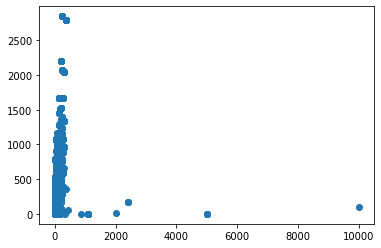

In [97]:
plt.scatter(df_final.movie_gross_worldwide,df_final.movie_budget)

# Gender and oscar wins visualization
### Crosstab normalize

In [71]:
show_details = pd.crosstab(df_final['is_female'], df_final['oscar_win_for_this_movie'], normalize= 'index')
show_details

oscar_win_for_this_movie,0,1
is_female,,
0,0.996436,0.003564
1,0.995467,0.004533


In [149]:
show_details = pd.crosstab(df_final['is_female'], df_final['oscar_win_for_this_movie'])
show_details

oscar_win_for_this_movie,0,1
is_female,,
0,38866,139
1,29867,136


### pie plot

([<matplotlib.patches.Wedge at 0x20cd2b5cc70>,
 [Text(-0.20556605345031587, 1.0806213942305891, 'female'),
  Text(0.20556615462539202, -1.0806213749841014, 'male')])

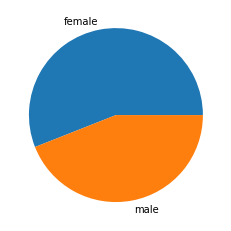

In [171]:
dict={'female': 0.004533, 'male': 0.003564}
plt.pie(dict.values(),labels=['female','male'])

## Chi-squared test, there seems to be a relationship between those 2 variables

In [83]:
show_details = pd.crosstab(df_final['is_female'], df_final['oscar_win_for_this_movie'])

chi2_contingency(show_details)

(3.773214825864007,
 0.05207944610016746,
 1,
 array([[38849.5633115,   155.4366885],
        [29883.4366885,   119.5633115]]))

# Genre and oscar wins visualization


In [88]:
show_details = pd.crosstab(df_final['movie_genre'], df_final['oscar_win_for_this_movie'], normalize= 'index')

show_details

oscar_win_for_this_movie,0,1
movie_genre,,
-1,1.000000,0.000000
1,0.990467,0.009533
2,0.999542,0.000458
3,0.997800,0.002200
4,0.997592,0.002408
5,0.999431,0.000569
6,0.994850,0.005150
7,0.980164,0.019836
8,1.000000,0.000000


In [147]:
show_details = pd.crosstab(df_final['movie_genre'], df_final['oscar_win_for_this_movie'])

show_details

oscar_win_for_this_movie,0,1
movie_genre,,
-1,97,0
1,12779,123
2,2181,1
3,907,2
4,19884,48
5,15814,9
6,5795,30
7,2273,46
8,370,0


## Pie plot
### Shows genres of the movies that the actor won in.

([<matplotlib.patches.Wedge at 0x20cd2af6820>,
 [Text(0.18137365393459545, 1.0849440527780285, 'Drama'),
  Text(-1.0442073190567884, 0.3458772539908267, 'Horror'),
  Text(-1.055444692911677, 0.30989756405072927, 'Western'),
  Text(-1.0554399370960799, -0.3099137608797375, 'Comedy'),
  Text(-0.6516283013689013, -0.8862169919692809, 'Action'),
  Text(-0.20611071914746848, -1.0805176405096373, 'Crime'),
  Text(0.6914452334448387, -0.8555135820934772, 'Biography'),
  Text(1.0741911711992436, -0.23688251880963637, 'Adventure'),
  Text(1.0982063351287648, -0.06279208137215496, 'Film-Noir'),
  Text(1.0997129441084992, -0.02512848105670095, 'Romance')])

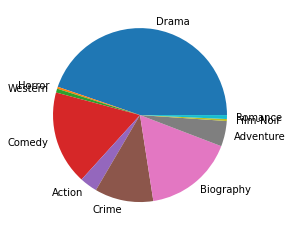

In [170]:
dict = {'Drama' : 0.447272, 'Horror' : 0.003636, 'Western' : 0.007272, 'Comedy' : 0.174545, 'Action':0.032727, 'Crime': 0.10909, 'Biography' : 0.167272, 'Adventure': 0.047272, 'Film-Noir' : 0.003636, 'Romance': 0.007272}

keys = dict.keys()
values = dict.values()
plt.pie(dict.values(),labels=keys)

## We can see here that the most of the movies in our database are comedy, action and drama

  0%|          | 0/29 [00:00<?, ?it/s]d:\python final project\pythonfinalproject\venv\lib\site-packages\pandas\core\series.py:2136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)
100%|██████████| 29/29 [00:00<00:00, 220.28it/s]

{1: 12902, 2: 2182, 3: 909, 4: 19932, 5: 15823, 6: 5825, 7: 2319, 8: 370, 9: 33, 10: 3876, 11: 43, 12: 269, 13: 1714, 14: 294, 15: 106, 16: 66, 17: 178, 18: 1052, 19: 208, 20: 216, 21: 51, 22: 162, -1: 97, 23: 274, 24: 28, 25: 18, 26: 33, 27: 10, 28: 18}


([<matplotlib.patches.Wedge at 0x20c48d710d0>,
 [Text(0.9156446820859033, 0.6095857742498632, '1'),
  Text(0.3216365689024172, 1.0519267643446861, '2'),
  Text(0.17092044894859904, 1.086639866805562, '3'),
  Text(-0.783532723786944, 0.7720598880624564, '4'),
  Text(-0.7262085790543096, -0.8262088717194465, '5'),
  Text(0.2875216927144462, -1.0617585771815643, '6'),
  Text(0.6526822142805703, -0.8854410918642821, '7'),
  Text(0.7559202038357004, -0.7991149137846154, '8'),
  Text(0.7704532022300563, -0.7851126436209342, '9'),
  Text(0.8972660278941914, -0.636328276274896, '10'),
  Text(0.9959510881666467, -0.4669918949828493, '11'),
  Text(1.0024834679107038, -0.45279895822067534, '12'),
  Text(1.0392226858177995, -0.3605776050750228, '13'),
  Text(1.0677995991019404, -0.2642044968537358, '14'),
  Text(1.0724334635753443, -0.24471711465238907, '15'),
  Text(1.074316777263601, -0.23631221316290477, '16'),
  Text(1.0768754264330156, -0.22436424836571178, '17'),
  Text(1.0877444732689792, -

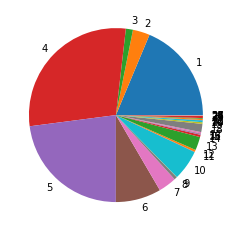

In [103]:
dict={}
for genre in tqdm(df_final['movie_genre'].unique()):
     df_filt=df_final[df_final['movie_genre']==genre]
     df_filt['movie_name'].drop_duplicates(inplace=True)
     count_gen=len(df_filt.index)
     dict[genre]=count_gen
keys = dict.keys()
values = dict.values()
print(dict)
plt.pie(dict.values(),labels=keys)

# Oscar win of the actor and movie rating

In [111]:
show_details = pd.crosstab(df_final['movie_rating_binned'], df_final['oscar_win_for_this_movie'], normalize= 'index')

show_details

oscar_win_for_this_movie,0,1
movie_rating_binned,,
-1.0,1.000000,0.000000
1.0,1.000000,0.000000
2.0,1.000000,0.000000
3.0,1.000000,0.000000
4.0,1.000000,0.000000
5.0,0.999820,0.000180
6.0,0.998498,0.001502
7.0,0.991106,0.008894
8.0,0.992184,0.007816


In [151]:
show_details = pd.crosstab(df_final['movie_rating_binned'], df_final['oscar_win_for_this_movie'])

show_details

oscar_win_for_this_movie,0,1
movie_rating_binned,,
-1.0,2577,0
1.0,63,0
2.0,452,0
3.0,1304,0
4.0,3567,0
5.0,11098,2
6.0,21937,33
7.0,20951,188
8.0,6474,51


([<matplotlib.patches.Wedge at 0x20cd2ba5b80>,
 [Text(1.1, 0.0, '1'),
  Text(1.1, 0.0, '2'),
  Text(1.1, 0.0, '3'),
  Text(1.1, 0.0, '4'),
  Text(1.0996233016303891, 0.028785317637339856, '5'),
  Text(1.0599337605175805, 0.29417753706743277, '6'),
  Text(-0.23089775840752017, 1.0754934798325755, '7'),
  Text(-0.5278788931468147, -0.9650615908687352, '8'),
  Text(0.9819915335054179, -0.49567391309577497, '9')])

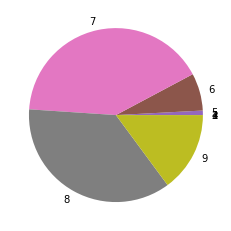

In [172]:
dict = {1 : 0, 2: 0, 3:0, 4 : 0, 5 : 0.000180, 6 : 0.001502, 7 : 0.008894, 8 : 0.007816, 9 : 0.003215}

keys = dict.keys()
values = dict.values()
plt.pie(dict.values(),labels=keys)

In [113]:
show_details = pd.crosstab(df_final['movie_rating_binned'], df_final['oscar_win_for_this_movie'])

chi2_contingency(show_details)

(258.96062238613365,
 1.277294290475439e-50,
 9,
 array([[2.56673054e+03, 1.02694615e+01],
        [6.27489422e+01, 2.51057848e-01],
        [4.50198760e+02, 1.80124044e+00],
        [1.29880350e+03, 5.19649896e+00],
        [3.55278534e+03, 1.42146563e+01],
        [1.10557660e+04, 4.42340019e+01],
        [2.18824486e+04, 8.75514433e+01],
        [2.10547601e+04, 8.42398707e+01],
        [6.49899758e+03, 2.60024200e+01],
        [3.09760651e+02, 1.23934906e+00]]))

# Actor oscar win and occupation

In [115]:
show_details = pd.crosstab(df_final['is_actor_model'], df_final['oscar_win_for_this_movie'], normalize= 'index')
show_details = pd.crosstab(df_final['is_actor_author'], df_final['oscar_win_for_this_movie'], normalize= 'index')
show_details = pd.crosstab(df_final['is_actor_comedian'], df_final['oscar_win_for_this_movie'], normalize= 'index')
show_details = pd.crosstab(df_final['is_actor_in_business'], df_final['oscar_win_for_this_movie'], normalize= 'index')
show_details = pd.crosstab(df_final['is_actor_director'], df_final['oscar_win_for_this_movie'], normalize= 'index')
show_details = pd.crosstab(df_final['is_actor_singer'], df_final['oscar_win_for_this_movie'], normalize= 'index')
show_details = pd.crosstab(df_final['is_actor_dancer'], df_final['oscar_win_for_this_movie'], normalize= 'index')
show_details

oscar_win_for_this_movie,0,1
is_actor_model,,
0.0,0.995918,0.004082
1.0,0.998258,0.001742


In [162]:
show_details = pd.crosstab(df_final['is_actor_dancer'], df_final['oscar_win_for_this_movie'])
show_details

oscar_win_for_this_movie,0,1
is_actor_dancer,,
0.0,67070,265
1.0,1663,10


([<matplotlib.patches.Wedge at 0x20d7c041d90>,
 [Text(1.093448935042941, 0.11987254253355273, 'model'),
  Text(0.888698570404281, 0.6482398097628589, 'author'),
  Text(0.21984714232787406, 1.077806677475264, 'comedian'),
  Text(-0.2566914928236809, 1.0696305331804765, 'business'),
  Text(-1.0974096776323046, 0.07544534073726325, 'director'),
  Text(0.3523123082623273, -1.042053759384261, 'singer'),
  Text(1.0738766372112203, -0.23830436011940945, 'dancer')])

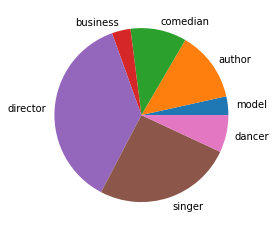

In [163]:
dict = {'model' : 0.018181, 'author' : 0.06857, 'comedian':0.05454, 'business' : 0.01818, 'director' : 0.19272, 'singer' : 0.13454, 'dancer' : 0.03636}

keys = dict.keys()
values = dict.values()
plt.pie(dict.values(),labels=keys)

# Actor education and actor oscar win

In [164]:
show_details = pd.crosstab(df_final['actor_education'], df_final['oscar_win_for_this_movie'])
show_details

oscar_win_for_this_movie,0,1
actor_education,,
-1,63416,229
1,979,5
2,603,6
3,665,5
4,350,5
5,276,1
6,400,3
7,363,1
8,231,0


([<matplotlib.patches.Wedge at 0x20d7e5779a0>,
 [Text(1.0364891308922903, 0.3683616179003251, 'new york uni'),
  Text(0.5060748135631795, 0.9766720447913892, 'julliard'),
  Text(-0.2967754371666531, 1.0592092993806947, 'uni of california'),
  Text(-0.8986589869820276, 0.6343595393122391, 'northwestern uni'),
  Text(-1.0769873275735447, 0.22382648691786852, 'carnegie mellon'),
  Text(-1.0974374418564667, -0.07504039719733684, 'uni of southern california'),
  Text(-1.0364961340267511, -0.36834191201599575, 'columbia uni'),
  Text(-0.8986831147489739, -0.6343253575769163, 'academy of dramatic arts'),
  Text(-3.862103731289128e-07, -1.0999999999999324, 'yale'),
  Text(0.9398727637356911, -0.5715235673074507, 'harvard'),
  Text(1.0769956830870504, -0.22378627887307512, 'state uni of new york'),
  Text(1.0974359789665338, -0.07506178834643823, 'stanford')])

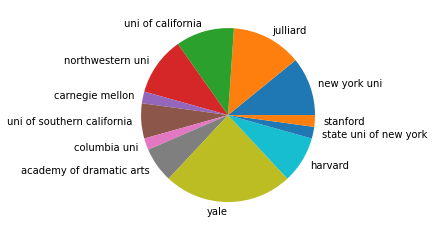

In [167]:
dict = {'new york uni' : 0.018181, 'julliard' : 0.021818, 'uni of california':0.018181, 'northwestern uni' : 0.018181, 'carnegie mellon' : 0.003636, 'uni of southern california' : 0.010909, 'columbia uni' : 0.003636, 'academy of dramatic arts': 0.010909, "yale": 0.04, "harvard": 0.014545 , 'state uni of new york': 0.003636, 'stanford': 0.003636}

keys = dict.keys()
values = dict.values()
plt.pie(dict.values(),labels=keys)

## Here we examine the connection between the variables gross from the movie and the actor winning an oscar for this movie

d:\python final project\pythonfinalproject\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='oscar_win_for_this_movie', ylabel='movie_gross_worldwide'>

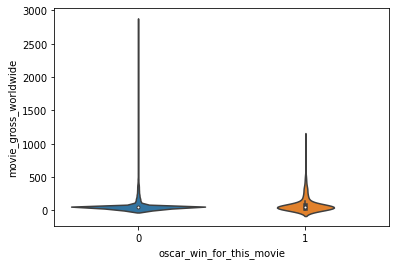

In [137]:
sns.violinplot(df_final.oscar_win_for_this_movie,df_final.movie_gross_worldwide)


In [ ]:
sns.swarmplot(x=df_final.oscar_win_for_this_movie, y=df_final.movie_gross_worldwide, data=df_final)

# Movie gross and genre
## Scatter plot

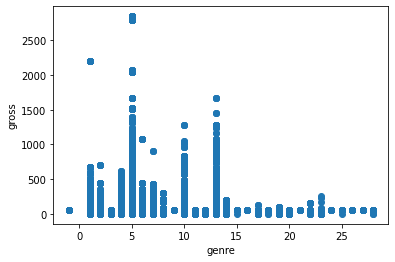

In [139]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(df_final.movie_genre, df_final.movie_gross_worldwide)
plt.xlabel('genre')
plt.ylabel('gross')
plt.show()

# Movie gross and rating
## Visualization

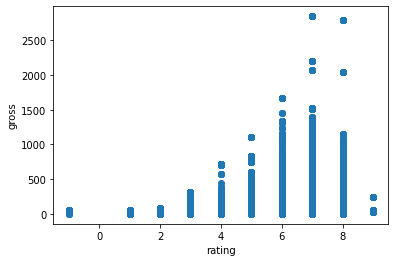

In [109]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(df_final.movie_rating_binned, df_final.movie_gross_worldwide)
plt.xlabel('rating')
plt.ylabel('gross')
plt.show()

In [ ]:
df_final = pd.read_csv("final_i_hope.csv", low_memory=False)

In [ ]:
df_final_please['movie_rating_binned'] = df_final_please['movie_rating_binned'].replace(999, -1)
df_final_please['movie_genre'] = df_final_please['movie_genre'].replace(999, -1)
df_final_please['actor_education'] = df_final_please['actor_education'].replace(999, -1)
df_final_please['actor_birth_place'] = df_final_please['actor_birth_place'].replace(999, -1)
df_final_please['Years_born_binned'] = df_final_please['Years_born_binned'].replace(999, -1)
df_final_please

In [110]:
df_final_please.to_csv("22_1.csv")

# Visualization of the ages of the oscar winners

In [111]:
show_details = pd.crosstab(df_final['actor_age_when_won_binned'], df_final['oscar_win_for_this_movie'])

show_details

oscar_win_for_this_movie,0.0,1.0
actor_age_when_won_binned,,
1,0,1
2,0,2
3,0,52
4,0,79
5,0,84
6,0,28
7,0,18
999,68733,12


([<matplotlib.patches.Wedge at 0x2b306150550>,
 [Text(1.0999287410206067, 0.012520570147698473, '0-10'),
  Text(1.098860040968941, 0.0500660599781685, '11-20'),
  Text(0.8688634586802436, 0.674593425827887, '21-30'),
  Text(-0.6032970333345281, 0.919800353103736, '31-40'),
  Text(-0.7134403780059811, -0.8372591158241772, '41-50'),
  Text(0.5927883683526437, -0.9266077651011838, '51-60'),
  Text(0.9766736646634212, -0.5060716873654594, '61-70'),
  Text(1.0897545183468005, -0.1497834762005911, '71-80')])

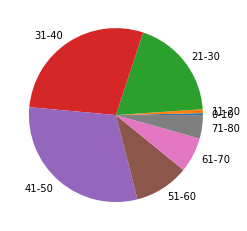

In [3]:
dict = {'0-10' : 1, '11-20' : 2, '21-30' : 52, '31-40' : 79, '41-50' : 84, '51-60' : 28, '61-70' : 18, '71-80' : 12}

keys = dict.keys()
values = dict.values()
plt.pie(dict.values(),labels=keys)

# We took the movie genres and their average rating and show it in a plot bar

In [ ]:
dict={}
for genre in tqdm(df_final['movie_genre'].unique()):
    if(genre != -1):
        df_filt=df_final[df_final['movie_genre']==genre]
        avg=df_filt['movie_rating_binned'].mean()
        dict[genre]=avg

print(dict)

<BarContainer object of 28 artists>

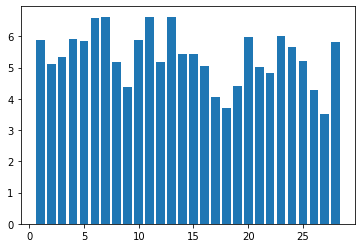

In [78]:
keys = dict.keys()
values = dict.values()

plt.bar(keys, values)

In [86]:
df_final.to_csv("final_please.csv")

In [2]:
df_final = pd.read_csv("22_1.csv", low_memory=False)

# Changed the missing values of the movie budget and gross to the overall mean and devided everything by 1 million

In [4]:
df_final['movie_budget'].mean()

15037846.437812459

In [5]:
df_final['movie_budget'] = df_final['movie_budget'].replace(0, df_final['movie_budget'].mean())
df_final['movie_gross_worldwide'] = df_final['movie_gross_worldwide'].replace(0, df_final['movie_gross_worldwide'].mean())
del df_final['Unnamed: 0']
del df_final['Unnamed: 0.1']
del df_final['Unnamed: 0.1.1']
del df_final['Unnamed: 0.1.1.1']
del df_final['Unnamed: 0.1.1.1.1']

df_final['movie_budget'] = df_final['movie_budget'] / 1000000
df_final['movie_gross_worldwide'] = df_final['movie_gross_worldwide'] / 1000000
df_final

df_final.to_csv('24_1.csv')

In [14]:
df_final = pd.read_csv("24_1.csv", low_memory=False)
df_final.to_csv

# Machine learning
## global help functions

In [5]:
def find_best_decision_tree_params(X_train, y_train):
    parameters = {'max_depth':[2,4,6],"min_samples_split":[5,10,20] }
    dt = tree.DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters,scoring=make_scorer(metrics.f1_score))
    clf.fit(X_train, y_train)
    best_max_depth=clf.best_params_['max_depth']
    best_min_samples_split=clf.best_params_['min_samples_split']
    return best_max_depth, best_min_samples_split

def find_best_random_forest_num_estimators(X_train, y_train):
    parameters = {'n_estimators':[11,51,71,100,150] }
    rf = RandomForestClassifier()
    clf = GridSearchCV(rf, parameters,scoring=make_scorer(metrics.f1_score))
    clf.fit(X_train, y_train)
    best_num_estimators=clf.best_params_['n_estimators']
    return best_num_estimators

def find_best_model(X_train, y_train, max_depth_val, min_samples_split_val,best_num_estimators):
    arr=[]
    gnb = GaussianNB()
    decisionTree = tree.DecisionTreeClassifier(max_depth=max_depth_val, min_samples_split=min_samples_split_val)
    svm=SVC()
    forest = RandomForestClassifier(n_estimators=best_num_estimators)
    scoresG = cross_val_score(gnb, X_train, y_train, cv=10,scoring='recall')
    arr.append(scoresG.mean())
    scoresT = cross_val_score(decisionTree, X_train, y_train, cv=10,scoring='recall')
    arr.append(scoresT.mean())
    scoresS = cross_val_score(svm, X_train, y_train, cv=10,scoring='recall')
    arr.append(scoresS.mean())
    scoresF = cross_val_score(forest, X_train, y_train, cv=10,scoring='recall')
    arr.append(scoresF.mean())
    if(max(arr)==scoresG.mean()):
        best_clf=gnb
        best_recall_val=max(arr)
        return best_clf, best_recall_val
    if(max(arr)==scoresT.mean()):
        best_clf=decisionTree
        best_recall_val=max(arr)
        return best_clf, best_recall_val
    if(max(arr)==scoresS.mean()):
        best_clf=svm
        best_recall_val=max(arr)
        return best_clf, best_recall_val
    if(max(arr)==scoresF.mean()):
        best_clf=forest
        best_recall_val=max(arr)
        return best_clf, best_recall_val

def predict(classifier, X_test, y_test):
    y_pred=classifier.predict(X_test)
    resDF=pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
    return resDF

def scale_features(X_train):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        return scaler, X_train_scaled

def scale_test_features(X_test,scaler):
    X_test_scaled = scaler.transform(X_test)
    return X_test_scaled

def train_classifier(X_train, y_train,best_model):
    clf_model = best_model.fit(X_train, y_train)
    return clf_model

def find_best_k_for_KNN(X_train, y_train):
    parameters = {'n_neighbors':[3,5,7,11] }
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters,scoring=make_scorer(metrics.f1_score))
    clf.fit(X_train, y_train)
    best_K=clf.best_params_['n_neighbors']
    best_f1_val=clf.best_score_
    return  best_K,best_f1_val


In [44]:
df_final['movie_budget'].astype(np.float64)
df_final['movie_gross_worldwide'].astype(np.float64)
df_final.to_csv("TESTOOOOOOO.csv")

In [60]:
print(df_final['movie_budget'].dtype)
print(df_final['oscar_win_for_this_movie'].dtype)
df_final['oscar_win_for_this_movie']= df_final['oscar_win_for_this_movie'].astype(int)
print(df_final['oscar_win_for_this_movie'].dtype)
np.any(np.isnan(df_final['oscar_win_for_this_movie']))
np.all(np.isfinite(df_final['oscar_win_for_this_movie']))

float64
int32
int32


True

In [73]:
df_final.to_csv("Is_there_a_null.csv")

In [6]:
df_final = pd.read_csv("Is_there_a_null.csv", low_memory=False)

In [3]:
df_final = pd.read_csv("final_countdown.csv", low_memory=False)

## Random Forest algorithm
### and a confusion matrix to examine the result

In [82]:
#Random Forest

def machine_learning_forest(df):
    df_cloned = df.copy()
    df_cloned=df_cloned.drop(columns=["actor_age_when_won_binned","actor_year_won_oscar","actor_name","movie_keyword","movie_name", "Years_born_binned",'Unnamed: 0', 'is_actor_model', 'is_actor_in_business', 'is_actor_author', 'is_actor_musician', 'is_actor_dancer', 'is_actor_comedian', 'is_actor_singer'])
    label_column = "oscar_win_for_this_movie"
    TRAINING_FEATURES = df_cloned.columns[df_cloned.columns != label_column]
    TARGET_FEATURE = label_column
    X = df_cloned[TRAINING_FEATURES]
    y = df_cloned[TARGET_FEATURE]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    best_num_estimators=find_best_random_forest_num_estimators(X_train, y_train)
    # forest = RandomForestClassifier(n_estimators=best_num_estimators)
    forest =  RandomForestClassifier(bootstrap=True, n_estimators=best_num_estimators, random_state=0)
    trained_model= train_classifier(X_train, y_train,forest)
    y_pred_train = trained_model.predict(X_train)
    print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
    y_pred = trained_model.predict(X_test)
    print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
    result = predict(trained_model, X_test, y_test)
    result_of_confusion_matrix = confusion_matrix(result['Actual'], result['Predicted'])
    print(result_of_confusion_matrix)
    result.to_csv("data_check_forest.csv")


machine_learning_forest(df_final)


Accuracy on training data=  0.9985689961236097
Accuracy on test data=  0.996087523547312
[[13745     7]
 [   47     3]]


## Desicion Tree algorithm
### and a confusion matrix to examine the result

In [89]:
#decision tree

def machine_learning_decision_tree(df):
    df_cloned = df.copy()
    df_cloned=df_cloned.drop(columns=["actor_age_when_won_binned","actor_year_won_oscar","actor_name","movie_keyword","movie_name", "Years_born_binned", 'Unnamed: 0','is_actor_dancer','is_actor_model', 'is_actor_comedian', 'is_female'])
    label_column = "oscar_win_for_this_movie"
    TRAINING_FEATURES = df_cloned.columns[df_cloned.columns != label_column]
    TARGET_FEATURE = label_column
    X = df_cloned[TRAINING_FEATURES]
    y = df_cloned[TARGET_FEATURE]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    best_max_depth,best_min_samples_split= find_best_decision_tree_params(X_train, y_train)
    # best_model, score= find_best_model(X_train, y_train, best_max_depth, best_min_samples_split,best_num_estimators)
    # print(best_model,score)
    decisionTree = tree.DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
    trained_model= train_classifier(X_train, y_train, decisionTree)
    y_pred_train = trained_model.predict(X_train)
    y_pred = trained_model.predict(X_test)
    print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
    print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
    result = predict(trained_model, X_test, y_test)
    result.to_csv("data_check_decision_tree.csv")
    result_of_confusion_matrix = confusion_matrix(result['Actual'], result['Predicted'])
    print(result_of_confusion_matrix)
    featuresDF=pd.DataFrame({"features":TRAINING_FEATURES,"weights":trained_model.feature_importances_})
    print(featuresDF.sort_values("weights",ascending=False))


machine_learning_decision_tree(df_final)


Accuracy on training data=  0.9961236097525631
Accuracy on test data=  0.9962324300825968
[[13749     3]
 [   49     1]]
                   features   weights
3    is_main_actor_in_movie  0.226859
5              movie_budget  0.193093
1         actor_birth_place  0.133978
2   movie_has_won_the_oscar  0.133205
6     movie_gross_worldwide  0.125450
13      movie_rating_binned  0.076720
0           actor_education  0.053812
11        is_actor_director  0.045414
12          is_actor_singer  0.005317
4               movie_genre  0.002163
8         is_actor_musician  0.002082
7           is_actor_active  0.000822
10     is_actor_in_business  0.000788
9           is_actor_author  0.000299


## Logistic Regression algorithm
### and a confusion matrix to examine the result

In [96]:
#logistic regression

def machine_learning_logistic_regression(df):
    df_cloned = df.copy()
    df_cloned=df_cloned.drop(columns=["actor_age_when_won_binned","actor_year_won_oscar","actor_name","movie_keyword","movie_name", "Years_born_binned", 'Unnamed: 0', 'is_actor_model', 'is_actor_in_business', 'is_actor_author', 'is_actor_musician', 'is_actor_comedian'])
    label_column = "oscar_win_for_this_movie"
    TRAINING_FEATURES = df_cloned.columns[df_cloned.columns != label_column]
    TARGET_FEATURE = label_column
    X = df_cloned[TRAINING_FEATURES]
    y = df_cloned[TARGET_FEATURE]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    scaler,X_train_standard_scaled = scale_features(X_train)
    X_test_standard_scaled = scale_test_features(X_test,scaler)
    #trained_model= train_classifier(X_train, y_train,LogisticRegression())
    trained_stand_model= train_classifier(X_train_standard_scaled, y_train, LogisticRegression())
    y_pred_train = trained_stand_model.predict(X_train_standard_scaled)
    print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
    y_pred = trained_stand_model.predict(X_test_standard_scaled)
    print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
    result = predict(trained_stand_model, X_test_standard_scaled, y_test)
    result.to_csv("data_check_logistic_regression.csv")
    result_of_confusion_matrix = confusion_matrix(result['Actual'], result['Predicted'])
    print(result_of_confusion_matrix)
    score = trained_stand_model.score(X_test_standard_scaled, y_test)
    print(score)


machine_learning_logistic_regression(df_final)

Accuracy on training data=  0.9958700141288991
Accuracy on test data=  0.9963048833502391
[[13751     1]
 [   50     0]]
0.9963048833502391


In [26]:
#Random Forest

from imblearn.over_sampling import SMOTE

# Oversample using SMOTE


def machine_learning_forest(df):
    df_cloned = df.copy()
    df_cloned=df_cloned.drop(columns=["actor_age_when_won_binned","actor_year_won_oscar","actor_name","movie_keyword","movie_name", "Years_born_binned",'Unnamed: 0', 'is_actor_model', 'is_actor_in_business', 'is_actor_author', 'is_actor_musician', 'is_actor_dancer', 'is_actor_comedian', 'is_actor_singer'])
    label_column = "oscar_win_for_this_movie"
    for x in range(6):
        TRAINING_FEATURES = df_cloned.columns[df_cloned.columns != label_column]
        TARGET_FEATURE = label_column
        X = df_cloned[TRAINING_FEATURES]
        y = df_cloned[TARGET_FEATURE]
        sm = SMOTE(random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
        x_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
        best_num_estimators=find_best_random_forest_num_estimators(x_train_smote, y_train_smote)
        # forest = RandomForestClassifier(n_estimators=best_num_estimators)
        forest =  RandomForestClassifier(bootstrap=True, n_estimators=best_num_estimators, random_state=0)
        trained_model= train_classifier(x_train_smote, y_train_smote,forest)
        y_pred_train = trained_model.predict(x_train_smote)
        print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train_smote, y_pred = y_pred_train))
        y_pred = trained_model.predict(X_test)
        print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
        result = predict(trained_model, X_test, y_test)
        result_of_confusion_matrix = confusion_matrix(result['Actual'], result['Predicted'])
        print(result_of_confusion_matrix)
        result.to_csv("data_check_forest_methods.csv")


machine_learning_forest(df_final)

Accuracy on training data=  0.9910337552742616
Accuracy on test data=  0.9774670337632227
[[13483   266]
 [   45     8]]
Accuracy on training data=  0.9925630954978544
Accuracy on test data=  0.9846399072598174
[[13588   149]
 [   63     2]]
Accuracy on training data=  0.9928988379916713
Accuracy on test data=  0.9823214026952616
[[13554   188]
 [   56     4]]
Accuracy on training data=  0.9908431237042156
Accuracy on test data=  0.9796406317924938
[[13513   234]
 [   47     8]]
Accuracy on training data=  0.991824894514768
Accuracy on test data=  0.9830459353716853
[[13564   185]
 [   49     4]]
Accuracy on training data=  0.9910600603877915
Accuracy on test data=  0.9777568468337922
[[13490   265]
 [   42     5]]


In [24]:
#logistic regression
from imblearn.over_sampling import SMOTE

# Oversample using SMOTE

def machine_learning_logistic_regression(df):
    df_cloned = df.copy()
    df_cloned=df_cloned.drop(columns=["actor_age_when_won_binned","actor_year_won_oscar","actor_name","movie_keyword","movie_name", "Years_born_binned", 'Unnamed: 0', 'is_actor_model', 'is_actor_in_business', 'is_actor_author', 'is_actor_musician', 'is_actor_comedian'])
    label_column = "oscar_win_for_this_movie"
    for x in range(6):
        TRAINING_FEATURES = df_cloned.columns[df_cloned.columns != label_column]
        TARGET_FEATURE = label_column
        X = df_cloned[TRAINING_FEATURES]
        y = df_cloned[TARGET_FEATURE]
        sm = SMOTE(random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
        x_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
        scaler,X_train_standard_scaled = scale_features(x_train_smote)
        X_test_standard_scaled = scale_test_features(X_test,scaler)
        #trained_model= train_classifier(X_train, y_train,LogisticRegression())
        trained_stand_model= train_classifier(X_train_standard_scaled, y_train_smote, LogisticRegression())
        y_pred_train = trained_stand_model.predict(X_train_standard_scaled)
        print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train_smote, y_pred = y_pred_train))
        y_pred = trained_stand_model.predict(X_test_standard_scaled)
        print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
        result = predict(trained_stand_model, X_test_standard_scaled, y_test)
        result.to_csv("data_check_logistic_regression_methods.csv")
        result_of_confusion_matrix = confusion_matrix(result['Actual'], result['Predicted'])
        print(result_of_confusion_matrix)
        score = trained_stand_model.score(X_test_standard_scaled, y_test)
        print(score)


machine_learning_logistic_regression(df_final)

Accuracy on training data=  0.8644929513415188
Accuracy on test data=  0.8516157078684249
[[11715  2043]
 [    5    39]]
0.8516157078684249
Accuracy on training data=  0.8777953528962583
Accuracy on test data=  0.8604550065207941
[[11823  1908]
 [   18    53]]
0.8604550065207941
Accuracy on training data=  0.8785550625545534
Accuracy on test data=  0.8566149833357485
[[11777  1964]
 [   15    46]]
0.8566149833357485
Accuracy on training data=  0.8694217130387343
Accuracy on test data=  0.8597304738443704
[[11819  1924]
 [   12    47]]
0.8597304738443704
Accuracy on training data=  0.8573650037284252
Accuracy on test data=  0.8497319229097232
[[11682  2068]
 [    6    46]]
0.8497319229097232
Accuracy on training data=  0.8722514231671608
Accuracy on test data=  0.8642950297058397
[[11888  1862]
 [   11    41]]
0.8642950297058397


In [25]:
#decision tree
from imblearn.over_sampling import SMOTE

# Oversample using SMOTE
def machine_learning_decision_tree(df):
    df_cloned = df.copy()
    df_cloned=df_cloned.drop(columns=["actor_age_when_won_binned","actor_year_won_oscar","actor_name","movie_keyword","movie_name", "Years_born_binned", 'Unnamed: 0','is_actor_dancer','is_actor_model', 'is_actor_comedian', 'is_female'])
    label_column = "oscar_win_for_this_movie"
    for x in range(6):
        TRAINING_FEATURES = df_cloned.columns[df_cloned.columns != label_column]
        TARGET_FEATURE = label_column
        X = df_cloned[TRAINING_FEATURES]
        y = df_cloned[TARGET_FEATURE]
        sm = SMOTE(random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
        x_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
        best_max_depth,best_min_samples_split= find_best_decision_tree_params(x_train_smote, y_train_smote)
        # best_model, score= find_best_model(X_train, y_train, best_max_depth, best_min_samples_split,best_num_estimators)
        # print(best_model,score)
        decisionTree = tree.DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
        trained_model= train_classifier(x_train_smote, y_train_smote, decisionTree)
        y_pred_train = trained_model.predict(x_train_smote)
        y_pred = trained_model.predict(X_test)
        print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train_smote, y_pred = y_pred_train))
        print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
        result = predict(trained_model, X_test, y_test)
        result.to_csv("data_check_decision_tree_methods.csv")
        result_of_confusion_matrix = confusion_matrix(result['Actual'], result['Predicted'])
        print(result_of_confusion_matrix)
        # featuresDF=pd.DataFrame({"features":TRAINING_FEATURES,"weights":trained_model.feature_importances_})
        # print(featuresDF.sort_values("weights",ascending=False))


machine_learning_decision_tree(df_final)

Accuracy on training data=  0.9544503855667104
Accuracy on test data=  0.9331256339660918
[[12843   906]
 [   17    36]]
Accuracy on training data=  0.945023463931027
Accuracy on test data=  0.9300825967251123
[[12805   950]
 [   15    32]]
Accuracy on training data=  0.9528845804081336
Accuracy on test data=  0.9329807274308072
[[12846   905]
 [   20    31]]
Accuracy on training data=  0.9527272727272728
Accuracy on test data=  0.9451528763947254
[[13003   730]
 [   27    42]]
Accuracy on training data=  0.9512496816676974
Accuracy on test data=  0.9339226199101579
[[12866   893]
 [   19    24]]
Accuracy on training data=  0.9494490308033604
Accuracy on test data=  0.9370381104187799
[[12888   851]
 [   18    45]]


In [18]:
#Undersampling
from imblearn.under_sampling import EditedNearestNeighbours


#Random Forest

def machine_learning_forest(df):
    df_cloned = df.copy()
    df_cloned=df_cloned.drop(columns=["actor_age_when_won_binned","actor_year_won_oscar","actor_name","movie_keyword","movie_name", "Years_born_binned",'Unnamed: 0', 'is_actor_model', 'is_actor_in_business', 'is_actor_author', 'is_actor_musician', 'is_actor_dancer', 'is_actor_comedian', 'is_actor_singer'])
    label_column = "oscar_win_for_this_movie"
    TRAINING_FEATURES = df_cloned.columns[df_cloned.columns != label_column]
    TARGET_FEATURE = label_column
    X = df_cloned[TRAINING_FEATURES]
    y = df_cloned[TARGET_FEATURE]
    enn = EditedNearestNeighbours()
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    x_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)
    best_num_estimators=find_best_random_forest_num_estimators(X_train, y_train)
    # forest = RandomForestClassifier(n_estimators=best_num_estimators)
    forest =  RandomForestClassifier(bootstrap=True, n_estimators=best_num_estimators, random_state=0)
    trained_model= train_classifier(x_train_enn, y_train_enn,forest)
    y_pred_train = trained_model.predict(x_train_enn)
    print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train_enn, y_pred = y_pred_train))
    y_pred = trained_model.predict(X_test)
    print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
    result = predict(trained_model, X_test, y_test)
    result_of_confusion_matrix = confusion_matrix(result['Actual'], result['Predicted'])
    print(result_of_confusion_matrix)
    result.to_csv("data_check_forest_methods2.csv")


machine_learning_forest(df_final)

Accuracy on training data=  0.9993434490808287
Accuracy on test data=  0.9936965657151138
[[13711    39]
 [   48     4]]


In [102]:
#Undersampling
from imblearn.under_sampling import EditedNearestNeighbours



def machine_learning_logistic_regression(df):
    df_cloned = df.copy()
    df_cloned=df_cloned.drop(columns=["actor_age_when_won_binned","actor_year_won_oscar","actor_name","movie_keyword","movie_name", "Years_born_binned", 'Unnamed: 0', 'is_actor_model', 'is_actor_in_business', 'is_actor_author', 'is_actor_musician', 'is_actor_comedian'])
    label_column = "oscar_win_for_this_movie"
    TRAINING_FEATURES = df_cloned.columns[df_cloned.columns != label_column]
    TARGET_FEATURE = label_column
    X = df_cloned[TRAINING_FEATURES]
    y = df_cloned[TARGET_FEATURE]
    enn = EditedNearestNeighbours()
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    x_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)
    scaler,X_train_standard_scaled = scale_features(x_train_enn)
    X_test_standard_scaled = scale_test_features(X_test,scaler)
    #trained_model= train_classifier(X_train, y_train,LogisticRegression())
    trained_stand_model= train_classifier(X_train_standard_scaled, y_train_enn, LogisticRegression())
    y_pred_train = trained_stand_model.predict(X_train_standard_scaled)
    print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train_enn, y_pred = y_pred_train))
    y_pred = trained_stand_model.predict(X_test_standard_scaled)
    print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
    result = predict(trained_stand_model, X_test_standard_scaled, y_test)
    result.to_csv("data_check_logistic_regression_methods2.csv")
    result_of_confusion_matrix = confusion_matrix(result['Actual'], result['Predicted'])
    print(result_of_confusion_matrix)
    score = trained_stand_model.score(X_test_standard_scaled, y_test)
    print(score)


machine_learning_logistic_regression(df_final)

Accuracy on training data=  0.9958427539931441
Accuracy on test data=  0.9963773366178814
[[13751     1]
 [   49     1]]
0.9963773366178814


In [103]:
#Undersampling

from imblearn.under_sampling import EditedNearestNeighbours

def machine_learning_decision_tree(df):
    df_cloned = df.copy()
    df_cloned=df_cloned.drop(columns=["actor_age_when_won_binned","actor_year_won_oscar","actor_name","movie_keyword","movie_name", "Years_born_binned", 'Unnamed: 0','is_actor_dancer','is_actor_model', 'is_actor_comedian', 'is_female'])
    label_column = "oscar_win_for_this_movie"
    TRAINING_FEATURES = df_cloned.columns[df_cloned.columns != label_column]
    TARGET_FEATURE = label_column
    X = df_cloned[TRAINING_FEATURES]
    y = df_cloned[TARGET_FEATURE]
    enn = EditedNearestNeighbours()
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    x_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)
    best_max_depth,best_min_samples_split= find_best_decision_tree_params(x_train_enn, y_train_enn)
    # best_model, score= find_best_model(X_train, y_train, best_max_depth, best_min_samples_split,best_num_estimators)
    # print(best_model,score)
    decisionTree = tree.DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
    trained_model= train_classifier(x_train_enn, y_train_enn, decisionTree)
    y_pred_train = trained_model.predict(x_train_enn)
    y_pred = trained_model.predict(X_test)
    print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train_enn, y_pred = y_pred_train))
    print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
    result = predict(trained_model, X_test, y_test)
    result.to_csv("data_check_decision_tree_methods2.csv")
    result_of_confusion_matrix = confusion_matrix(result['Actual'], result['Predicted'])
    print(result_of_confusion_matrix)
    # featuresDF=pd.DataFrame({"features":TRAINING_FEATURES,"weights":trained_model.feature_importances_})
    # print(featuresDF.sort_values("weights",ascending=False))


machine_learning_decision_tree(df_final)

Accuracy on training data=  0.9961260141802499
Accuracy on test data=  0.9962324300825968
[[13749     3]
 [   49     1]]
